# Instalando extensão Verilog

In [127]:
!pip install git+https://github.com/lesc-ufv/cad4u
!git clone https://github.com/lesc-ufv/cad4u
%load_ext plugin

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/lesc-ufv/cad4u to /tmp/pip-req-build-d2mwo6dj
  Running command git clone -q https://github.com/lesc-ufv/cad4u /tmp/pip-req-build-d2mwo6dj
fatal: destination path 'cad4u' already exists and is not an empty directory.
The plugin extension is already loaded. To reload it, use:
  %reload_ext plugin


# Instalando riscV-assembler

In [128]:
!pip install riscv-assembler

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Montador RiscV
Executando códigos para ser reaproveitados abaixo

In [129]:
%%writefile simple.s
add x1,x1,x1

Overwriting simple.s


In [130]:
from riscv_assembler.convert import AssemblyConverter
!rm -f -r simple/*
def assemble():
  cnv = AssemblyConverter(output_type = "t") #just text
  cnv.convert("simple.s")
  # Using readlines()
  file1 = open('simple/txt/simple.txt', 'r')
  Lines = file1.readlines()
  file1 = open('im_data.txt', 'w')


  for line in Lines:
    decimal_representation = int(line, 2)
    hexadecimal_string = hex(decimal_representation)
    file1.write(hexadecimal_string[2:]+'\n')

  file1.close()

# Risc-V

# Arquivos de registradores

In [131]:
%%writefile rm_data.txt
0
01
02
03
04
05
06
07
08
09
0A
0B
0C
0D
0E
0F
10
11
12
13

Overwriting rm_data.txt


## Memória de dados

In [132]:
%%writefile dm_data.txt
0
1
2
03
04
05
06
07
08
09
10
11
12
13
14
15
16
17
18
19

Overwriting dm_data.txt


## Memória de instruções

#### Exemplo de programa

In [133]:
%%writefile simple.s
add x1,x2,x3
add x4,x5,x6
add x7,x8,x9
sub x10,x11,x12
add x1,x1,x1

Overwriting simple.s


In [134]:
from riscv_assembler.convert import AssemblyConverter
!rm -f -r simple/*
cnv = AssemblyConverter(output_type = "t") #just text
cnv.convert("simple.s")
# Using readlines()
file1 = open('simple/txt/simple.txt', 'r')
Lines = file1.readlines()
file1 = open('im_data.txt', 'w')


for line in Lines:
   decimal_representation = int(line, 2)
   hexadecimal_string = hex(decimal_representation)
   file1.write(hexadecimal_string[2:]+'\n')

file1.close()

------Writing to Text file------
Output file: simple.txt
Number of instructions: 5


In [135]:
!cat simple/txt/simple.txt

00000000001100010000000010110011
00000000011000101000001000110011
00000000100101000000001110110011
01000000110001011000010100110011
00000000000100001000000010110011


In [136]:
!cat im_data.txt

3100b3
628233
9403b3
40c58533
1080b3


### Ou digite suas instruções RiscV diretamente, em modo hexadecimal

In [137]:
%%writefile im_data.txt
20090001
01294820
01e9502a
1140fffd
2129ffff
2129ffff
2129ffff

Overwriting im_data.txt


# Código dos 5 estágios do RiscV

## Arquivo verilog registrador genérico

In [138]:
%%writefile regr.v
module regr (	input clk,input clear,input hold,
	input wire [N-1:0] in,
	output reg [N-1:0] out);

	parameter N = 1;

	always @(posedge clk) begin
		if (clear)
			out <= {N{1'b0}};
		else if (hold)
			out <= out;
		else
			out <= in;
	end
endmodule


Overwriting regr.v


## Arquivo verilog de registrador e memória de instruções

In [139]:
%%writefile im_reg.v
module im(input wire			clk,input wire 	[31:0] 	addr,output wire [31:0] 	data);
	parameter NMEM = 128;   // Number of memory entries,
							// not the same as the memory size
	parameter IM_DATA = "im_data.txt";  // file to read data from
	reg [31:0] mem [0:127];  // 32-bit memory with 128 entries
	initial begin
		$readmemh(IM_DATA, mem, 0, NMEM-1);
	end
	assign data = mem[addr[8:2]][31:0];
endmodule

module regm(		input wire			clk,input wire  [4:0]	read1, read2,
		output wire [31:0]	data1, data2,input wire			regwrite, input wire	[4:0]	wrreg,input wire	[31:0]	wrdata);

	parameter NMEM = 20;   // Number of memory entries,
							// not the same as the memory size
	parameter RM_DATA = "rm_data.txt";  // file to read data from

	reg [31:0] mem [0:31];  // 32-bit memory with 32 entries

	initial begin
		$readmemh(RM_DATA, mem, 0, NMEM-1);
	end
	reg [31:0] _data1, _data2;
	always @(*) begin
		if (read1 == 5'd0)
			_data1 = 32'd0;
		else if ((read1 == wrreg) && regwrite)
			_data1 = wrdata;
		else
			_data1 = mem[read1][31:0];
	end

	always @(*) begin
		if (read2 == 5'd0)
			_data2 = 32'd0;
		else if ((read2 == wrreg) && regwrite)
			_data2 = wrdata;
		else
			_data2 = mem[read2][31:0];
	end

	assign data1 = _data1;
	assign data2 = _data2;

	always @(posedge clk) begin
		if (regwrite && wrreg != 5'd0) begin
			// write a non $zero register
			mem[wrreg] <= wrdata;
		end
	end
endmodule


Overwriting im_reg.v


## Arquivo verilog memória de dados

In [140]:
%%writefile datam.v
module dm(
		input wire			clk,
		input wire	[6:0]	addr,
		input wire			rd, wr,
		input wire 	[31:0]	wdata,
		output wire	[31:0]	rdata);
	parameter NMEM = 20;   // Number of memory entries,
							// not the same as the memory size
	parameter RM_DATA = "dm_data.txt";  // file to read data from

	reg [31:0] mem [0:127];  // 32-bit memory with 128 entries

        initial begin
		$readmemh(RM_DATA, mem, 0, NMEM-1);
	end
		

	always @(posedge clk) begin
		if (wr) begin
			mem[addr] <= wdata;
		end
	end

	assign rdata = wr ? wdata : mem[addr];
	// During a write, avoid the one cycle delay by reading from 'wdata'

endmodule




Overwriting datam.v


## Alu e controle da Alu

In [141]:
%%writefile alu.v
module alu(
		input		[3:0]	ctl,
		input		[31:0]	a, b,
		output reg	[31:0]	out,
		output				zero);

	wire [31:0] sub_ab;
	wire [31:0] add_ab;
	wire 		oflow_add;
	wire 		oflow_sub;
	wire 		oflow;
	wire 		slt;

	assign zero = (0 == out);

	assign sub_ab = a - b;
	assign add_ab = a + b;
	assign oflow_add = (a[31] == b[31] && add_ab[31] != a[31]) ? 1 : 0;
	assign oflow_sub = (a[31] == b[31] && sub_ab[31] != a[31]) ? 1 : 0;
	assign oflow = (ctl == 4'b0010) ? oflow_add : oflow_sub;
	// set if less than, 2s compliment 32-bit numbers
	assign slt = oflow_sub ? ~(a[31]) : a[31];
	always @(*) begin
		case (ctl)
			4'd2:  out <= add_ab;				/* add */
			4'd0:  out <= a & b;				/* and */
			4'd12: out <= ~(a | b);			/* nor */
			4'd1:  out <= a | b;				/* or */
			4'd7:  out <= {{31{1'b0}}, slt};	/* slt */
			4'd6:  out <= sub_ab;				/* sub */
			4'd13: out <= a ^ b;				/* xor */
			default: out <= 0;
		endcase

	end

endmodule


module alu_control(
		input wire [3:0] funct,
		input wire [1:0] aluop,
		output reg [3:0] aluctl);

	reg [3:0] _funct;

	always @(*) begin
		case(funct[3:0])
			4'd0:  _funct = 4'd2;	 /* add */
			4'd8:  _funct = 4'd2;	 /* sub */

			4'd4:  	_funct = 4'd13; /* xorI */
			4'd12:  _funct = 4'd13; /* xorI */
			
			4'd5:  	_funct = 4'd1;	 /* or */
			4'd13:  _funct = 4'd1;	 /* or */
			
			4'd6:  _funct = 4'd13; /* xor */
			4'd14:  _funct = 4'd13; /* xor */
			
			4'd7:   _funct = 4'd0;  /* and */
			4'd15:  _funct = 4'd0;  /* and */
			
			4'd2: _funct = 4'd7;	 /* slt */
			4'd10: _funct = 4'd7;	 /* slt */
			default: _funct = 4'd0;
		endcase
	end

	always @(*) begin
		case(aluop)
			2'd0: aluctl = 4'd2;	/* add */
			2'd1: aluctl = 4'd6;	/* sub */
			2'd2: aluctl = _funct;
			2'd3: aluctl = 4'd2;	/* add */
			default: aluctl = 0;
		endcase
	end

endmodule


Overwriting alu.v


## Unidade de controle

In [142]:
%%writefile control.v
module control(
		input  wire	[6:0]	opcode,
		output reg			branch_eq, branch_ne, branch_lt,
		output reg [1:0]	aluop, alusrc,
		output reg			memread, memwrite, memtoreg,
		output reg			regdst, regwrite,
		output reg			jump,
    output reg [31:0] ImmGen,
    input [31:0] inst);
    wire[2:0] f3 = inst[14:12]; //funct3 para diferenciar as instruções de branch
	always @(*) begin
		/* defaults */
		aluop[1:0]		<= 2'b10;
		alusrc[1:0]		<= 2'b0;
		branch_eq	<= 1'b0;
		branch_ne	<= 1'b0;
		memread		<= 1'b0;
		memtoreg	<= 1'b0;
		memwrite	<= 1'b0;
		regdst		<= 1'b1;
		regwrite	<= 1'b1;
		jump		<= 1'b0;

		case (opcode)
     7'b0000011: begin // lw == 3
        	alusrc[1:0]   <= 2'b1;
          aluop[1:0]		<= 2'b00;
        	memtoreg <= 1'b1;                 
        	regwrite <= 1'b1;    
        	memread  <= 1'b1;
					ImmGen    <= {{20{inst[31]}},inst[31:20]};
        	
      	end
			7'b0010011: begin	/* i-type  */
				//regdst   		<= 1'b0; // rt or rd (only mips)
				aluop[1:0] 		<= 2'b10;
				alusrc[1:0]   <= 2'b01;
        ImmGen   <= {{20{inst[31]}},inst[31:20]};
			end

      7'b1100011: begin // beq == 99
          aluop  		<= 2'b1;
    	    ImmGen   	<= {{19{inst[31]}},inst[31],inst[7],inst[30:25],inst[11:8],1'b0};
          regwrite  <= 1'b0;
					alusrc[1:0] 		<= (f3 == 3'b110) ? 2'b10 : 2'b00;
          branch_eq <= (f3 == 3'b000) ? 1'b1 : 1'b0;
          branch_ne <= (f3 == 3'b001) ? 1'b1 : 1'b0;
					branch_lt <= (f3 == 3'b100 || f3 == 3'b110)? 1'b1 : 1'b0;


		  end
			7'b0100011: begin	/* sw */
				memwrite <= 1'b1;
				aluop[1] <= 1'b0;
				alusrc[1:0]   <= 2'b1;
				regwrite <= 1'b0;
        ImmGen   <= {{20{inst[31]}},inst[31:25],inst[11:7]};
			end
			7'b0110011: begin	/* add */
			end
			7'b1101111: begin	/* j jump */
				ImmGen   	<= {{11{inst[31]}},inst[31:13],2'b00};
				jump 			<= 1'b1;
			end
		endcase
	end
endmodule



Overwriting control.v


<img src="https://raw.githubusercontent.com/cacauvicosa/mips/master/michael/riscv/riscv-single/riscv-single.png" width="600">

## Processador RISCV


### RiscV Opcodes bits e Registradores


<img src="https://raw.githubusercontent.com/arduinoufv/inf251/main/figures/mips_opcode_regs.png" alt="wscad2020" width="300"/>  <img src="https://raw.githubusercontent.com/arduinoufv/inf251/main/figures/riscV_opcode_regs.png" alt="wscad2020" width="300"/> 

### Código de decodificação

In [143]:
%%writefile decodefields.v
    wire [5:0]  opcode; wire [6:0]  opcoderv; 
    wire [4:0]  rs;     wire [4:0]  rs1;
    wire [4:0]  rt;     wire [4:0]  rs2;
    wire [4:0]  rd;
    wire [6:0] func7; wire [2:0] func3;
    wire [15:0] imm;
    wire [4:0]  shamt;
    wire [31:0] seimm;  // sign extended immediate
    //
    assign opcode   = inst_s2[31:26];  assign opcoderv   = inst_s2[6:0]; 
    assign rs       = inst_s2[25:21];  assign rs2       = inst_s2[24:20];
    assign rt       = inst_s2[20:16];  assign rs1       = inst_s2[19:15];
    assign rd       = inst_s2[11:7];
  assign func7    = inst_s2[31:25];
    assign func3    = inst_s2[14:12];
    assign imm      = inst_s2[15:0];
    assign shamt    = inst_s2[10:6];
    assign seimm    = {{16{inst_s2[15]}}, inst_s2[15:0]};

  // register file
    wire [31:0] data1, data2;
    regm regm1(.clk(clk), .read1(rs1), .read2(rs2),
            .data1(data1), .data2(data2),
            .regwrite(regwrite_s5), .wrreg(wrreg_s5),
            .wrdata(wrdata_s5));

      // control (opcode -> ...)
    wire        regdst;
    wire        branch_eq_s2;
    wire        branch_ne_s2;
    wire      branch_lt_s2;
    wire        memread;
    wire        memwrite;
    wire        memtoreg;
    wire [1:0]  aluop;
    wire        regwrite;
    wire [1:0]  alusrc;
    wire        jump_s2;
  wire [31:0] ImmGen;  // RISCV
    //
  //agora passa blt para o control
    control ctl1(.opcode(opcoderv), .regdst(regdst),
                .branch_eq(branch_eq_s2), .branch_ne(branch_ne_s2), .branch_lt(branch_lt_s2),
                .memread(memread),
                .memtoreg(memtoreg), .aluop(aluop),
                .memwrite(memwrite), .alusrc(alusrc),
                .regwrite(regwrite), .jump(jump_s2), .ImmGen(ImmGen), .inst(inst_s2));

    // pass rs to stage 3 (for forwarding)
    wire [4:0] rs_s3;       wire [4:0] rs1_s3;
    regr #(.N(5)) regr_s2_rs(.clk(clk), .clear(1'b0), .hold(stall_s1_s2),
                .in(rs1), .out(rs1_s3));

    // transfer seimm, rt, and rd to stage 3
    wire [31:0] seimm_s3;
    wire [4:0]  rt_s3;    wire [4:0] rs2_s3;
    wire [4:0]  rd_s3;
    regr #(.N(32)) reg_s2_seimm(.clk(clk), .clear(flush_s2), .hold(stall_s1_s2),
                        .in(ImmGen), .out(seimm_s3));  // RISCV
    regr #(.N(10)) reg_s2_rt_rd(.clk(clk), .clear(flush_s2), .hold(stall_s1_s2),
                        .in({rs2, rd}), .out({rs2_s3, rd_s3}));

  // shift left, seimm
    wire [31:0] seimm_sl2;
    assign seimm_sl2 = {seimm[29:0], 2'b0};  // shift left 2 bits
    // branch address
    wire [31:0] baddr_s2;
    assign baddr_s2 = pc4_s2 + ImmGen;
    wire [31:0] jaddr_s2;
	  assign jaddr_s2 = pc4_s2 + ImmGen;

  wire [3:0] func_s3;
  
    regr #(.N(4)) func7_3_s2(.clk(clk), .clear(1'b0), .hold(stall_s1_s2),
                        .in({func7[5],func3}), .out(func_s3));

Overwriting decodefields.v


### RiscV Immediate and Funct Alucontrol

<img src="https://raw.githubusercontent.com/arduinoufv/inf251/main/figures/mips_imgen_aluctrl.png" alt="wscad2020" width="300"/>  <img src="https://raw.githubusercontent.com/arduinoufv/inf251/main/figures/imgen_aluctrl_RiscV.png" alt="wscad2020" width="300"/> 

### Estágio de execução

In [144]:
%%writefile execution_newcode.v
// ALU
	wire [31:0] alusrc_data1;
	wire [31:0] alusrc_data2;

	reg [31:0] _alusrc_data1,_alusrc_data2;


	// first  ALU input can come from data or unsigned
	// second ALU input can come from data or unsigned or an immediate value 

	always @(*) begin
		case (alusrc_s3)

		  // Instrucao tipo I
			2'b01: begin
				_alusrc_data1 <= fw_data1_s3;
				_alusrc_data2 <= seimm_s3;
			end
			// BLTU
			2'b10: begin
				_alusrc_data1 <= (fw_data1_s3[31] == 1'b1)? fw_data1_s3*(-1) : fw_data1_s3;
				_alusrc_data2 <= (fw_data2_s3[31] == 1'b1)? fw_data2_s3*(-1) : fw_data2_s3;
			end
			
			// Padrao tipo R
			default: begin 
				_alusrc_data1 <= fw_data1_s3;
				_alusrc_data2 <= fw_data2_s3;
			end
		endcase
	end
	assign alusrc_data1 = _alusrc_data1;
	assign alusrc_data2 = _alusrc_data2;

	// ALU control
	wire [3:0] aluctl;
	wire [5:0] funct;
	assign funct = seimm_s3[5:0];
	alu_control alu_ctl1(.funct(func_s3), .aluop(aluop_s3), .aluctl(aluctl));
	// ALU
	wire [31:0]	alurslt;
  wire zero_s3;
	alu alu1(.ctl(aluctl), .a(alusrc_data1), .b(alusrc_data2), .out(alurslt),
									.zero(zero_s3));

                  	// write register
	wire [4:0]	wrreg;
	wire [4:0]	wrreg_s4;
	assign wrreg = (regdst_s3) ? rd_s3 : rs2_s3;


Overwriting execution_newcode.v


### Mips e RISCV Formato de instruções

<img src="https://raw.githubusercontent.com/arduinoufv/inf251/main/figures/mips_formato_instrucoes.png" alt="wscad2020" width="500"/>  <img src="https://raw.githubusercontent.com/arduinoufv/inf251/main/figures/riscVaddsubaddildsd.png" alt="wscad2020" width="500"/> 

### DATAPATH

<img src="https://raw.githubusercontent.com/arduinoufv/inf251/main/figures/riscvhazard_forward.png" alt="wscad2020" width="800"/> 


### Código main

In [145]:
%%writefile main.v
/*
 * cpu. - five stage MIPS CPU.
 *
 */


`include "regr.v"
`include "im_reg.v"
`include "alu.v"
`include "control.v"
`include "datam.v"



module cpu(
        input wire clk);

    parameter NMEM = 7;  // number in instruction memory
    parameter IM_DATA = "im_data.txt";

    wire regwrite_s5;
    wire [4:0] wrreg_s5;
    wire [31:0] wrdata_s5;
    reg stall_s1_s2;

    // {{{ flush control
    reg flush_s1, flush_s2, flush_s3;
    always @(*) begin
        flush_s1 <= 1'b0;
        flush_s2 <= 1'b0;
        flush_s3 <= 1'b0;
        if (pcsrc | jump_s4) begin
            flush_s1 <= 1'b1;
            flush_s2 <= 1'b1;
            flush_s3 <= 1'b1;
        end
    end
    // }}}

    // {{{ stage 1, IF (fetch)

    reg  [5:0] clock_counter;
    initial begin
        clock_counter <= 6'd1;
    end
        always @(posedge clk) begin
                clock_counter <= clock_counter + 1;
    end

    reg  [31:0] pc;
    initial begin
        pc <= 32'd0;
    end

    wire [31:0] pc4;  // PC + 4
    assign pc4 = pc + 4;   

    always @(posedge clk) begin
        if (stall_s1_s2) 
            pc <= pc;
        else if (pcsrc == 1'b1)
            pc <= baddr_s4;
        else if (jump_s4 == 1'b1)
            pc <= jaddr_s4;
        else
            pc <= pc4;
    end

    // pass PC + 4 to stage 2
    wire [31:0] pc4_s2;
    regr #(.N(32)) regr_pc4_s2(.clk(clk),
                        .hold(stall_s1_s2), .clear(flush_s1),
                        .in(pc), .out(pc4_s2));

    // instruction memory
    wire [31:0] inst;
    wire [31:0] inst_s2;
    im #(.NMEM(NMEM), .IM_DATA(IM_DATA))
        im1(.clk(clk), .addr(pc), .data(inst));
    regr #(.N(32)) regr_im_s2(.clk(clk),
                        .hold(stall_s1_s2), .clear(flush_s1),
                        .in(inst), .out(inst_s2));

    // }}}

    // {{{ stage 2, ID (decode)

`include "decodefields.v"


    // transfer register data to stage 3
    wire [31:0] data1_s3, data2_s3;
    regr #(.N(64)) reg_s2_mem(.clk(clk), .clear(flush_s2), .hold(stall_s1_s2),
                .in({data1, data2}),
                .out({data1_s3, data2_s3}));


    // transfer PC + 4 to stage 3
    wire [31:0] pc4_s3;
    regr #(.N(32)) reg_pc4_s2(.clk(clk), .clear(1'b0), .hold(stall_s1_s2),
                        .in(pc4_s2), .out(pc4_s3));

    


    // transfer the control signals to stage 3
    wire        regdst_s3;
    wire        memread_s3;
    wire        memwrite_s3;
    wire        memtoreg_s3;
    wire [1:0]  aluop_s3;
    wire        regwrite_s3;
    wire [1:0]  alusrc_s3;
    // A bubble is inserted by setting all the control signals
    // to zero (stall_s1_s2).
    regr #(.N(9)) reg_s2_control(.clk(clk), .clear(stall_s1_s2), .hold(1'b0),
            .in({regdst, memread, memwrite,
                    memtoreg, aluop, regwrite, alusrc}),
            .out({regdst_s3, memread_s3, memwrite_s3,
                    memtoreg_s3, aluop_s3, regwrite_s3, alusrc_s3}));

    wire branch_eq_s3, branch_ne_s3, branch_lt_s3;
    regr #(.N(3)) branch_s2_s3(.clk(clk), .clear(flush_s2), .hold(1'b0),
                .in({branch_eq_s2, branch_ne_s2,branch_lt_s2}),
                .out({branch_eq_s3, branch_ne_s3,branch_lt_s3}));

    wire [31:0] baddr_s3;
    regr #(.N(32)) baddr_s2_s3(.clk(clk), .clear(flush_s2), .hold(1'b0),
                .in(baddr_s2), .out(baddr_s3));

    wire jump_s3;
    regr #(.N(1)) reg_jump_s3(.clk(clk), .clear(flush_s2), .hold(1'b0),
                .in(jump_s2),
                .out(jump_s3));

    wire [31:0] jaddr_s3;
    regr #(.N(32)) reg_jaddr_s3(.clk(clk), .clear(flush_s2), .hold(1'b0),
                .in(jaddr_s2), .out(jaddr_s3));
    // }}}

    // {{{ stage 3, EX (execute)

    reg [31:0] fw_data1_s3;
`include "execution_newcode.v"

    // transfer PC + 4 to stage 4
    wire [31:0] pc4_s4;
    regr #(.N(32)) reg_pc4_s4(.clk(clk), .clear(1'b0), .hold(stall_s1_s2),
                        .in(pc4_s3), .out(pc4_s4));

    // pass through some control signals to stage 4
    wire regwrite_s4;
    wire memtoreg_s4;
    wire memread_s4;
    wire memwrite_s4;
    regr #(.N(4)) reg_s3(.clk(clk), .clear(flush_s2), .hold(1'b0),
                .in({regwrite_s3, memtoreg_s3, memread_s3,
                        memwrite_s3}),
                .out({regwrite_s4, memtoreg_s4, memread_s4,
                        memwrite_s4}));


    always @(*)
    case (forward_a)
            2'd1: fw_data1_s3 = alurslt_s4;
            2'd2: fw_data1_s3 = wrdata_s5;
         default: fw_data1_s3 = data1_s3;
    endcase

    wire zero_s4;
    regr #(.N(1)) reg_zero_s3_s4(.clk(clk), .clear(1'b0), .hold(1'b0),
                    .in(zero_s3), .out(zero_s4));

    // pass ALU result and zero to stage 4
    wire [31:0] alurslt_s4;
    regr #(.N(32)) reg_alurslt(.clk(clk), .clear(flush_s3), .hold(1'b0),
                .in({alurslt}),
                .out({alurslt_s4}));

    // pass data2 to stage 4
    wire [31:0] data2_s4;
    reg [31:0] fw_data2_s3;
    always @(*)
    case (forward_b)
            2'd1: fw_data2_s3 = alurslt_s4;
            2'd2: fw_data2_s3 = wrdata_s5;
         default: fw_data2_s3 = data2_s3;
    endcase
    regr #(.N(32)) reg_data2_s3(.clk(clk), .clear(flush_s3), .hold(1'b0),
                .in(fw_data2_s3), .out(data2_s4));


    // pass to stage 4
    regr #(.N(5)) reg_wrreg(.clk(clk), .clear(flush_s3), .hold(1'b0),
                .in(wrreg), .out(wrreg_s4));

    wire branch_eq_s4, branch_ne_s4, branch_lt_s4;
    regr #(.N(3)) branch_s3_s4(.clk(clk), .clear(flush_s3), .hold(1'b0),
                .in({branch_eq_s3, branch_ne_s3,branch_lt_s3}),
                .out({branch_eq_s4, branch_ne_s4,branch_lt_s4}));

    wire [31:0] baddr_s4;
    regr #(.N(32)) baddr_s3_s4(.clk(clk), .clear(flush_s3), .hold(1'b0),
                .in(baddr_s3), .out(baddr_s4));

    wire jump_s4;
    regr #(.N(1)) reg_jump_s4(.clk(clk), .clear(flush_s3), .hold(1'b0),
                .in(jump_s3),
                .out(jump_s4));

    wire [31:0] jaddr_s4;
    regr #(.N(32)) reg_jaddr_s4(.clk(clk), .clear(flush_s3), .hold(1'b0),
                .in(jaddr_s3), .out(jaddr_s4));
    // }}}

    // {{{ stage 4, MEM (memory)
    
    // transfer PC + 4 to stage 5
    wire [31:0] pc4_s5;
    regr #(.N(32)) reg_pc4_s5(.clk(clk), .clear(1'b0), .hold(stall_s1_s2),
                        .in(pc4_s4), .out(pc4_s5));
    
    wire jump_s5;
    regr #(.N(1)) reg_jump_s5(.clk(clk), .clear(flush_s4), .hold(1'b0),
                .in(jump_s4),
                .out(jump_s5));

    // pass regwrite and memtoreg to stage 5
    wire memtoreg_s5;
    regr #(.N(2)) reg_regwrite_s4(.clk(clk), .clear(1'b0), .hold(1'b0),
                .in({regwrite_s4, memtoreg_s4}),
                .out({regwrite_s5, memtoreg_s5}));

    // data memory
    wire [31:0] rdata;
    dm dm1(.clk(clk), .addr(alurslt_s4[8:2]), .rd(memread_s4), .wr(memwrite_s4),
            .wdata(data2_s4), .rdata(rdata));
    // pass read data to stage 5
    wire [31:0] rdata_s5;
    regr #(.N(32)) reg_rdata_s4(.clk(clk), .clear(1'b0), .hold(1'b0),
                .in(rdata),
                .out(rdata_s5));

    // pass alurslt to stage 5
    wire [31:0] alurslt_s5;
    regr #(.N(32)) reg_alurslt_s4(.clk(clk), .clear(1'b0), .hold(1'b0),
                .in(alurslt_s4),
                .out(alurslt_s5));

    // pass wrreg to stage 5
    regr #(.N(5)) reg_wrreg_s4(.clk(clk), .clear(1'b0), .hold(1'b0),
                .in(wrreg_s4),
                .out(wrreg_s5));

    // branch
    reg pcsrc;
    always @(*) begin
        case (1'b1)
            branch_eq_s4: pcsrc <= zero_s4;
            branch_ne_s4: pcsrc <= ~(zero_s4);
            branch_lt_s4: pcsrc <= alurslt_s4[31];

            default: pcsrc <= 1'b0;
        endcase
    end
    // }}}
            
    // {{{ stage 5, WB (write back)

    reg [31:0] _wrdata_s5;
    always @(*) begin
        case ({jump_s5,memtoreg_s5})
        2'b01:
            _wrdata_s5 <= rdata_s5;
        
        2'b00:
            _wrdata_s5 <= alurslt_s5;
        
        2'b10:
            _wrdata_s5 <= (wrreg_s5 == 5'd0)? 32'd0: pc4_s5 + 4;
        default: 
            _wrdata_s5 <= alurslt_s5;

        endcase
    end

    assign wrdata_s5 = _wrdata_s5;

    // }}}

    // {{{ forwarding

    // stage 3 (MEM) -> stage 2 (EX)
    // stage 4 (WB) -> stage 2 (EX)

    reg [1:0] forward_a;
    reg [1:0] forward_b;
    always @(*) begin
        // If the previous instruction (stage 4) would write,
        // and it is a value we want to read (stage 3), forward it.

        // data1 input to ALU
        if ((regwrite_s4 == 1'b1) && (wrreg_s4 == rs1_s3)) begin
            forward_a <= 2'd1;  // stage 4
        end else if ((regwrite_s5 == 1'b1) && (wrreg_s5 == rs1_s3)) begin
            forward_a <= 2'd2;  // stage 5
        end else
            forward_a <= 2'd0;  // no forwarding

        // data2 input to ALU
        if ((regwrite_s4 == 1'b1) & (wrreg_s4 == rs2_s3)) begin
            forward_b <= 2'd1;  // stage 5
        end else if ((regwrite_s5 == 1'b1) && (wrreg_s5 == rs2_s3)) begin
            forward_b <= 2'd2;  // stage 5
        end else
            forward_b <= 2'd0;  // no forwarding
    end
    // }}}

    // {{{ load use data hazard detection, signal stall

    /* If an operation in stage 4 (MEM) loads from memory (e.g. lw)
     * and the operation in stage 3 (EX) depends on this value,
     * a stall must be performed.  The memory read cannot 
     * be forwarded because memory access is too slow.  It can
     * be forwarded from stage 5 (WB) after a stall.
     *
     *   lw $1, 16($10)  ; I-type, rt_s3 = $1, memread_s3 = 1
     *   sw $1, 32($12)  ; I-type, rt_s2 = $1, memread_s2 = 0
     *
     *   lw $1, 16($3)  ; I-type, rt_s3 = $1, memread_s3 = 1
     *   sw $2, 32($1)  ; I-type, rt_s2 = $2, rs_s2 = $1, memread_s2 = 0
     *
     *   lw  $1, 16($3)  ; I-type, rt_s3 = $1, memread_s3 = 1
     *   add $2, $1, $1  ; R-type, rs_s2 = $1, rt_s2 = $1, memread_s2 = 0
     */
    always @(*) begin
        if (memread_s3 == 1'b1 && ((rs2 == rd_s3) || (rs1 == rd_s3)) ) begin
            stall_s1_s2 <= 1'b1;  // perform a stall
        end else
            stall_s1_s2 <= 1'b0;  // no stall
    end
    // }}}

endmodule


module top;
reg clk;

initial begin
  clk=0;
     forever #1 clk = ~clk;  
end 
//altere aqui, de acordo com o numero de instruções no programa
parameter nInstrucoes = 50;
cpu #(nInstrucoes)CPU(clk);
initial begin
    $dumpfile("test.vcd");
    $dumpvars(0,top);
    #256
    $writememh("mem.data", top.CPU.dm1.mem, 0, 15);
    $writememh("reg.data", top.CPU.regm1.mem, 0, 15);
    $dumpoff;
    $finish;
    end

endmodule

Overwriting main.v


## Formas de onda

(Caso apareça warning relacionado a im_data.txt, desconsidere. Isso significa que a memória de dados está com poucas instruções)

In [146]:
%%verilog
`include "main.v"

VCD info: dumpfile test.vcd opened for output.



### Fetch

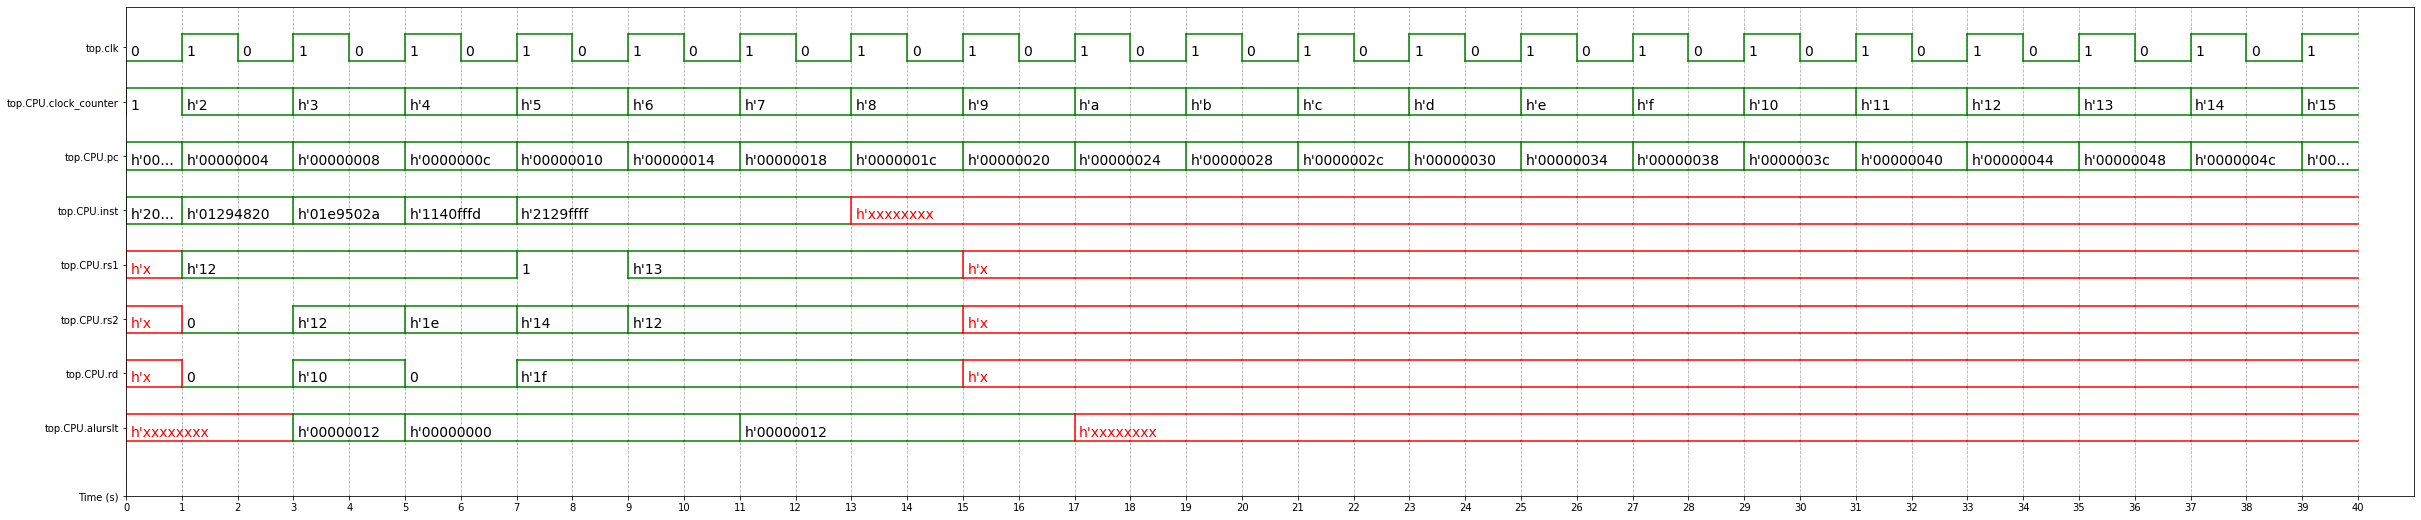

In [147]:
%%waveform test.vcd

sign_list = ['top.clk','top.CPU.clock_counter','top.CPU.pc','top.CPU.inst', 'top.CPU.rs1','top.CPU.rs2', 'top.CPU.rd','top.CPU.alurslt' ]
time_begin = 0
time_end = 40
base = 'hex' # bin, dec, dec2, hex, octal


### Decode

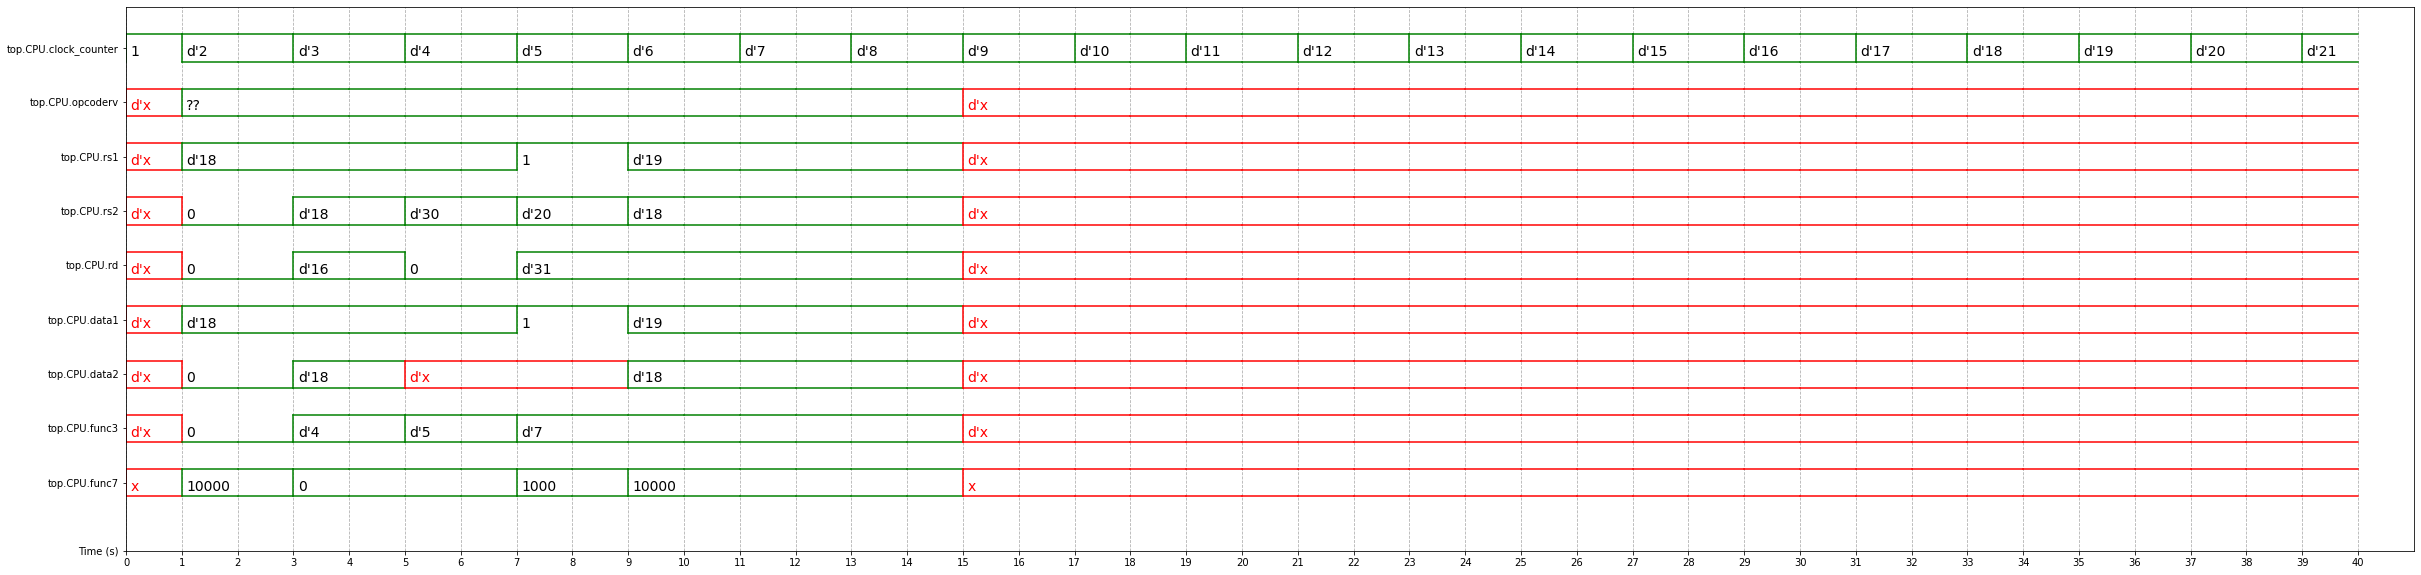

In [148]:
%%waveform test.vcd

op_dict = [{'110011':'ALU'}, {'10':'sp','111':'t2','1001':'s1', '1000':'s0','110':'t1','100':'tp','1':'ra','11':'gp', '101':'t0'} ]

sign_list = ['top.CPU.clock_counter','top.CPU.opcoderv,r[0]', 'top.CPU.rs1','top.CPU.rs2', 'top.CPU.rd','top.CPU.data1', 'top.CPU.data2' , 'top.CPU.func3', 'top.CPU.func7,b' ]
time_begin = 0
time_end = 40
base = 'dec' # bin, dec, dec2, hex, octal


### Execute

#### Add e Sub

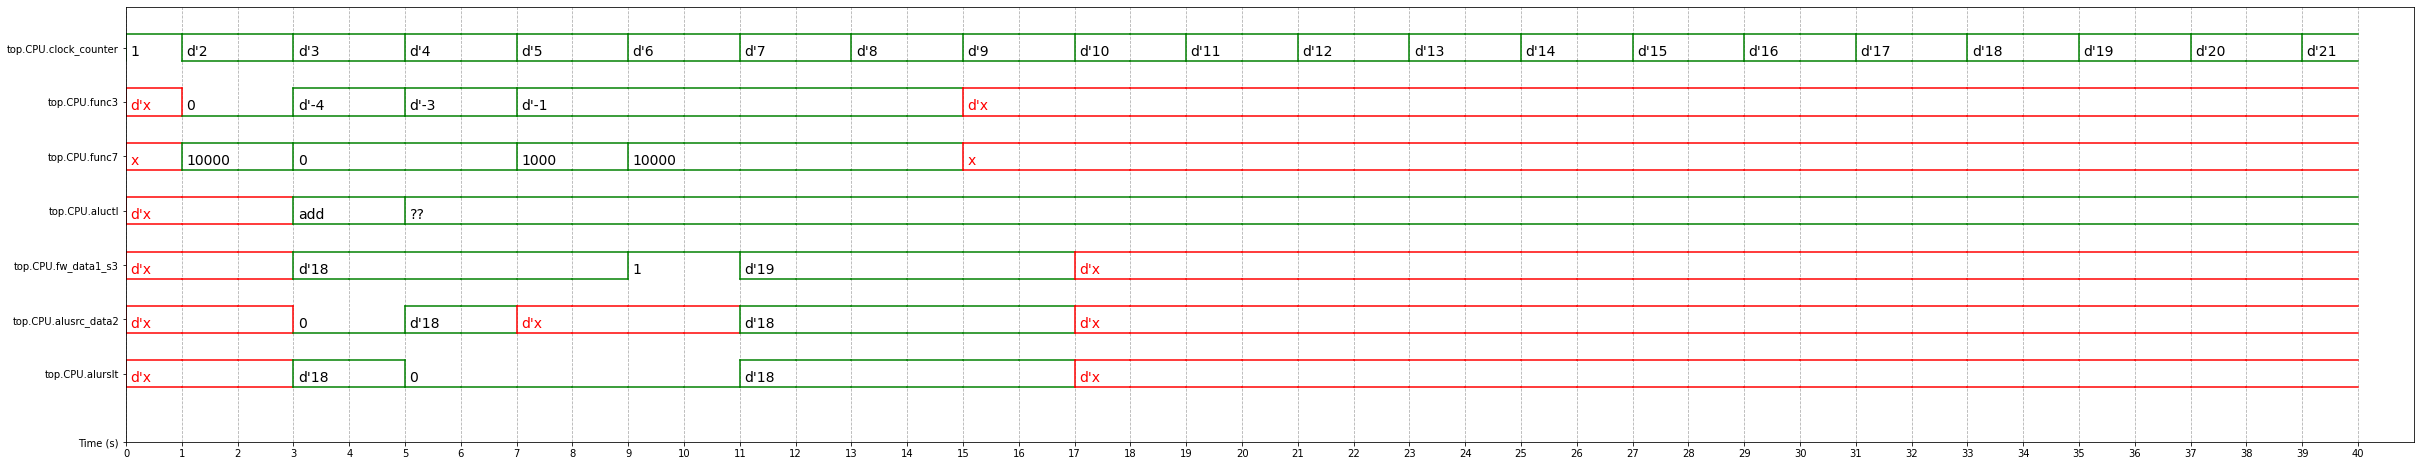

In [149]:
%%waveform test.vcd

op_dict = [{'10':'add','110':'sub'}, {'10':'sp','111':'t2','1001':'s1', '1000':'s0','110':'t1','100':'tp','1':'ra','11':'gp', '101':'t0'} ]

sign_list = ['top.CPU.clock_counter','top.CPU.func3', 'top.CPU.func7,b', 'top.CPU.aluctl,r[0]' , 'top.CPU.fw_data1_s3', 'top.CPU.alusrc_data2','top.CPU.alurslt']
time_begin = 0
time_end = 40
base = 'dec2' # bin, dec, dec2, hex, octal


#### Forward

In [150]:
%%writefile simple.s
add x2,x3,x4
sub x3,x5,x1
add x7,x2,x3

Overwriting simple.s


In [151]:
!rm -f -r simple/*
def assemble():
  cnv = AssemblyConverter(output_type = "t") #just text
  cnv.convert("simple.s")
  # Using readlines()
  file1 = open('simple/txt/simple.txt', 'r')
  Lines = file1.readlines()
  file1 = open('im_data.txt', 'w')


  for line in Lines:
    decimal_representation = int(line, 2)
    hexadecimal_string = hex(decimal_representation)
    file1.write(hexadecimal_string[2:]+'\n')

  file1.close()

assemble()

------Writing to Text file------
Output file: simple.txt
Number of instructions: 3


In [152]:
%%verilog 
`include "main.v"

VCD info: dumpfile test.vcd opened for output.



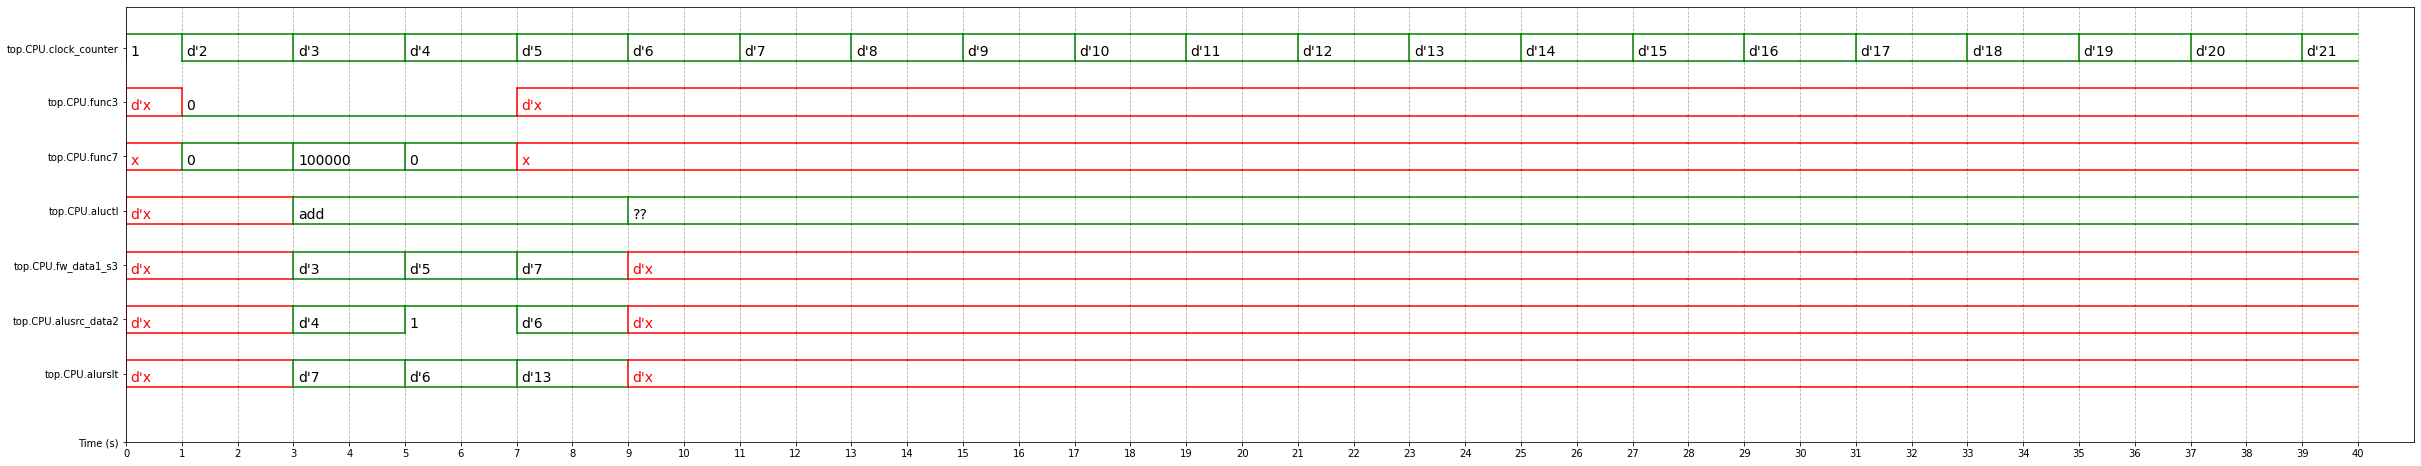

In [153]:
%%waveform test.vcd

op_dict = [{'10':'add','110':'sub'}, {'10':'sp','111':'t2','1001':'s1', '1000':'s0','110':'t1','100':'tp','1':'ra','11':'gp', '101':'t0'} ]

sign_list = ['top.CPU.clock_counter','top.CPU.func3', 'top.CPU.func7,b', 'top.CPU.aluctl,r[0]' , 'top.CPU.fw_data1_s3', 'top.CPU.alusrc_data2','top.CPU.alurslt']
time_begin = 0
time_end = 40
base = 'dec2' # bin, dec, dec2, hex, octal


#### Addi

In [154]:
%%writefile simple.s
add x2,x3,x4  
sub x3,x5,x1
add x7,x2,x3
addi x2,x0,5
addi x3,x1,-2

Overwriting simple.s


In [155]:
!rm -f -r simple/*
assemble()

------Writing to Text file------
Output file: simple.txt
Number of instructions: 5


In [156]:
!cat simple/txt/simple.txt

00000000010000011000000100110011
01000000000100101000000110110011
00000000001100010000001110110011
00000000010100000000000100010011
11111111111000001000000110010011


In [157]:
%%verilog 
`include "main.v"

VCD info: dumpfile test.vcd opened for output.



##### Decode

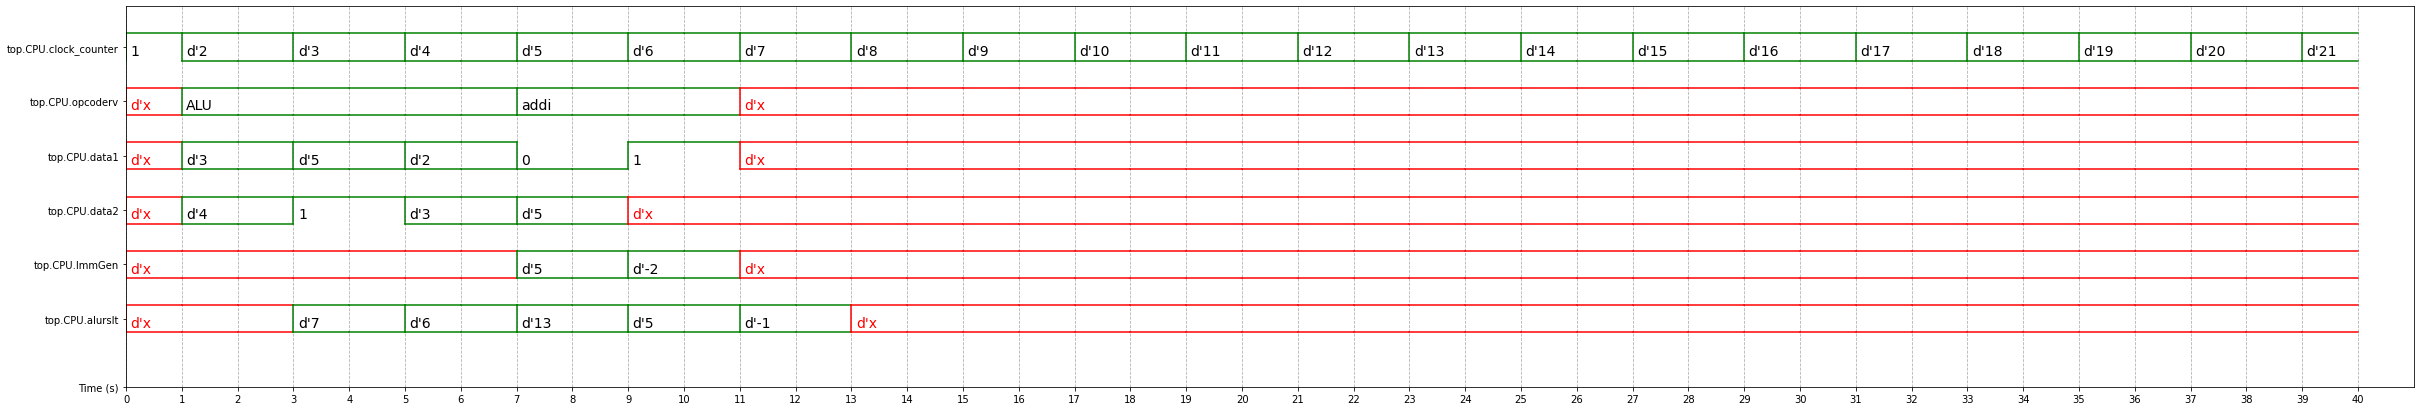

In [158]:
%%waveform test.vcd

op_dict = [{'10':'add','110':'sub'}, {'110011':'ALU','10011':'addi'},{'10':'sp','111':'t2','1001':'s1', '1000':'s0','110':'t1','100':'tp','1':'ra','11':'gp', '101':'t0'} ]

sign_list = ['top.CPU.clock_counter','top.CPU.opcoderv,r[1]' , 'top.CPU.data1', 'top.CPU.data2','top.CPU.ImmGen', 'top.CPU.alurslt']
time_begin = 0
time_end = 40
base = 'dec2' # bin, dec, dec2, hex, octal


##### Execute


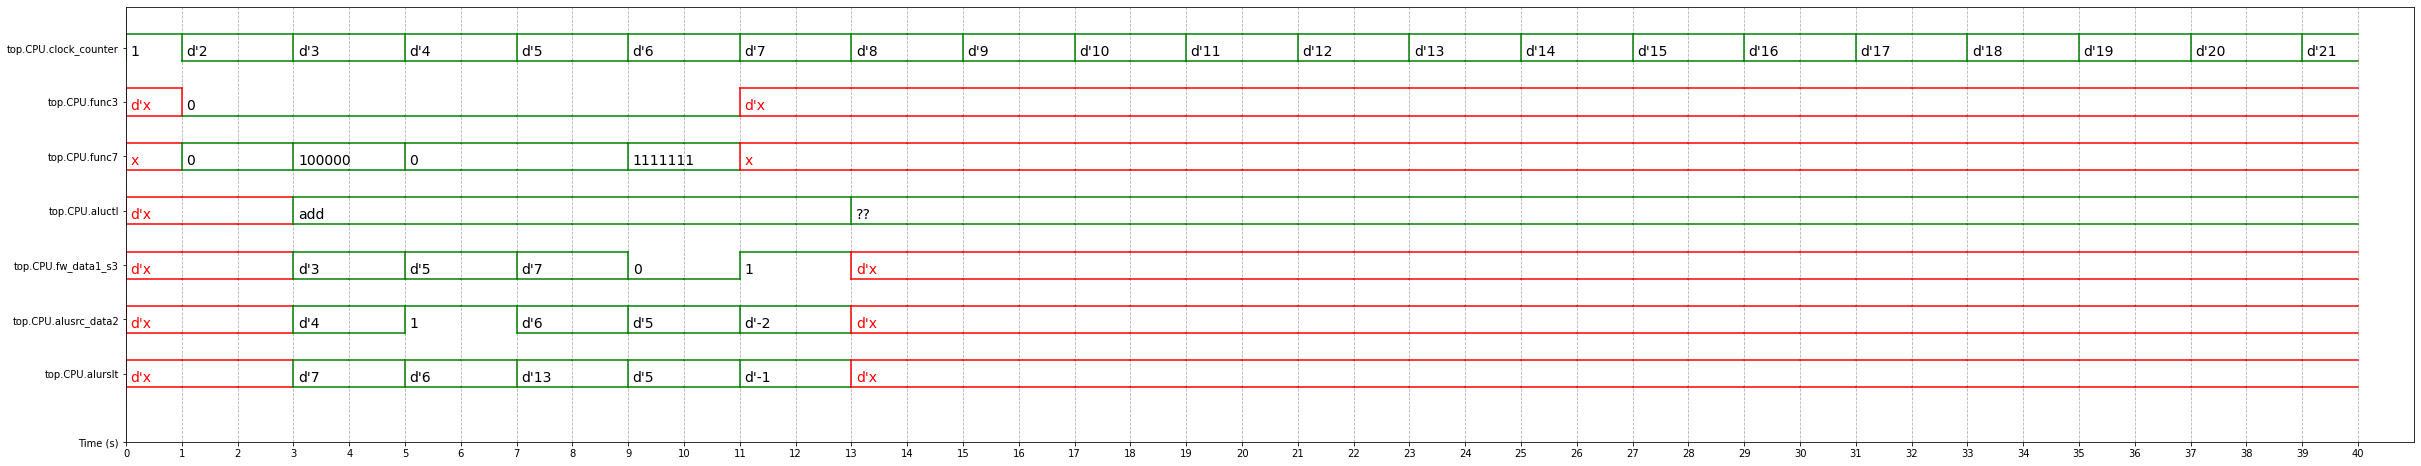

In [159]:
%%waveform test.vcd

op_dict = [{'10':'add','110':'sub'}, {'10':'sp','111':'t2','1001':'s1', '1000':'s0','110':'t1','100':'tp','1':'ra','11':'gp', '101':'t0'} ]

sign_list = ['top.CPU.clock_counter','top.CPU.func3', 'top.CPU.func7,b', 'top.CPU.aluctl,r[0]' , 'top.CPU.fw_data1_s3', 'top.CPU.alusrc_data2','top.CPU.alurslt']
time_begin = 0
time_end = 40
base = 'dec2' # bin, dec, dec2, hex, octal


##### Segundo Exemplo

In [160]:
%%writefile simple.s
addi x2,x0,5
addi x3,x1,-2
add x5,x3,x2  

Overwriting simple.s


In [161]:
!rm -f -r simple/*
assemble()

------Writing to Text file------
Output file: simple.txt
Number of instructions: 3


In [162]:
%%verilog 
`include "main.v"

VCD info: dumpfile test.vcd opened for output.



In [163]:
# Final Register file
!cat reg.data

// 0x00000000
00000000
00000001
00000005
ffffffff
00000004
00000004
00000006
00000007
00000008
00000009
0000000a
0000000b
0000000c
0000000d
0000000e
0000000f


#### Load and Store

##### Código de Teste para Load

* x2 = mem[x4+0] = mem[4+0/4] = mem[palavra 1] = 1
* x3 = mem[x4+12] = mem[4+12/4] = mem[palavra 4] = 4
* x1 = mem[x4+-4] = mem[4-4/4] = mem[palavra 0] = 0

Registro
```
0
0
1
4
4
5
6
....
```


In [164]:
%%writefile simple.s
lw x2,0(x4)
lw x3,12(x4)
lw x1,-4(x4)

Overwriting simple.s


In [165]:
!rm -f -r simple/*
assemble()

------Writing to Text file------
Output file: simple.txt
Number of instructions: 3


In [166]:
%%verilog 
`include "main.v"

VCD info: dumpfile test.vcd opened for output.



Resultado esperado para o Banco de Registradores
```
0
0
1
4
4
5
6
....
```

In [167]:
# Final Register file
!cat reg.data

// 0x00000000
00000000
00000000
00000001
00000004
00000004
00000005
00000006
00000007
00000008
00000009
0000000a
0000000b
0000000c
0000000d
0000000e
0000000f


##### Segundo Código de Teste

* lw x1,4(x8)
* add x2,x2,x2
* add x3,x2,x1

```
x1 = mem[4+8/4] = 3
x2 = 2+2 = 4
x3 = 4 + 3 = 7
```

Resultado final esperado para Registradores
```
0
3
4
7
5
6
....
```



In [168]:
%%writefile simple.s
lw x1,4(x8)
add x2,x2,x2
add x3,x2,x1

Overwriting simple.s


In [169]:
!rm -f -r simple/*
assemble()

------Writing to Text file------
Output file: simple.txt
Number of instructions: 3


In [170]:
!cat im_data.txt

442083
210133
1101b3


In [171]:
%%verilog 
`include "main.v"

VCD info: dumpfile test.vcd opened for output.



In [172]:
# Final Register file
!cat reg.data

// 0x00000000
00000000
00000003
00000004
00000007
00000004
00000005
00000006
00000007
00000008
00000009
0000000a
0000000b
0000000c
0000000d
0000000e
0000000f


##### Terceiro Teste do Lw e unidade de Hazard

In [173]:
%%writefile simple.s
add x2,x2,x2
lw x1,4(x8)
add x3,x2,x1

Overwriting simple.s


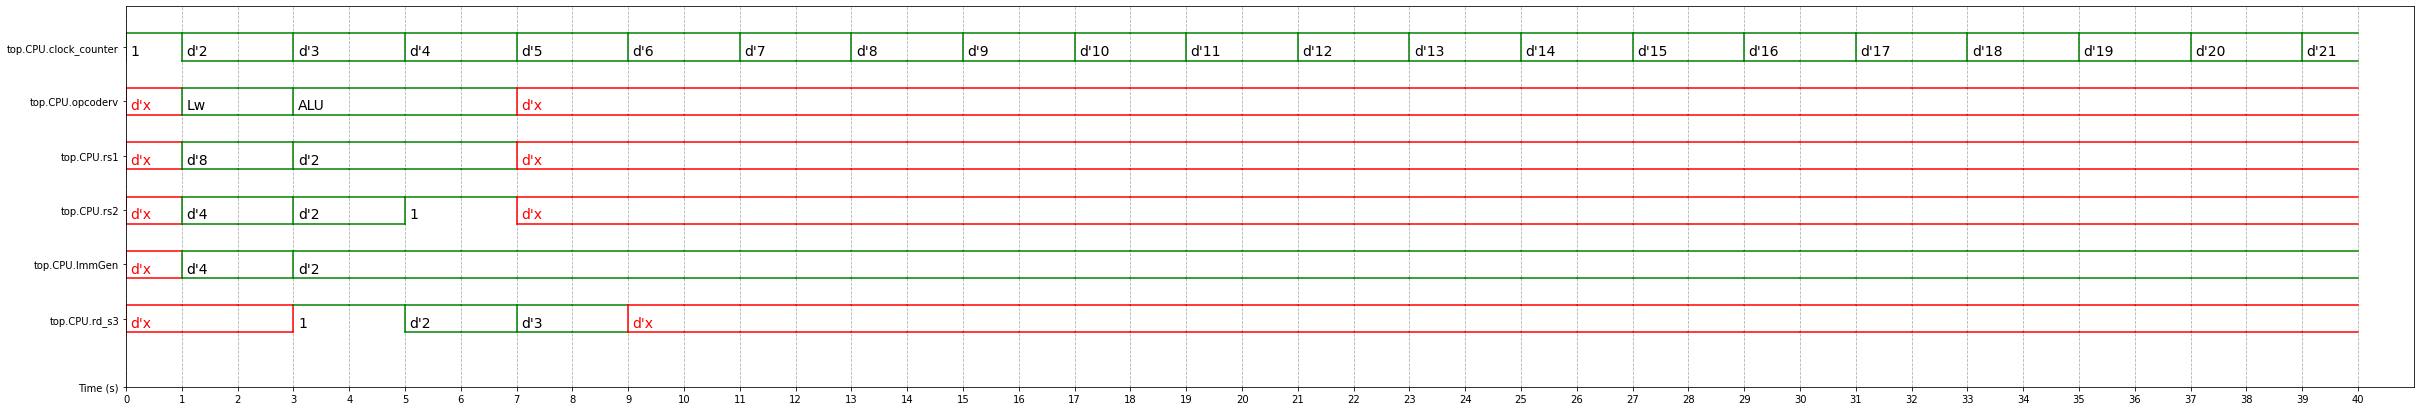

In [174]:
%%waveform test.vcd

op_dict = [{'10':'add','110':'sub'}, {'110011':'ALU','10011':'addi','11':'Lw'},{'10':'sp','111':'t2','1001':'s1', '1000':'s0','110':'t1','100':'tp','1':'ra','11':'gp', '101':'t0'} ]

sign_list = ['top.CPU.clock_counter','top.CPU.opcoderv,r[1]' , 'top.CPU.rs1', 'top.CPU.rs2','top.CPU.ImmGen', 'top.CPU.rd_s3']
time_begin = 0
time_end = 40
base = 'dec2' # bin, dec, dec2, hex, octal


Resultado final esperado para Registradores
```
0
3
4
7
5
6
....
```

In [175]:
# Final Register file
!cat reg.data

// 0x00000000
00000000
00000003
00000004
00000007
00000004
00000005
00000006
00000007
00000008
00000009
0000000a
0000000b
0000000c
0000000d
0000000e
0000000f


#### Branches

[Arquivo com os binários dos 2 exemplos](https://raw.githubusercontent.com/arduinoufv/inf251/main/riscv/exemplos_para_desvio.txt)

##### Código de Teste


In [176]:
%%writefile simple.s
beq x19,x10,8
add x18,x18,x10
addi x19,x19,-1
beq x0,x0,0
add x1,x1,x1

Overwriting simple.s


In [177]:
!rm -f -r simple/*
assemble()

------Writing to Text file------
Output file: simple.txt
Number of instructions: 5


In [178]:
!cat simple/txt/simple.txt

01111100101010011000101111100011
00000000101010010000100100110011
11111111111110011000100110010011
01111100000000000000101111100011
00000000000100001000000010110011


In [179]:
!cat im_data.txt

7ca98be3
a90933
fff98993
7c000be3
1080b3


In [180]:
%%verilog 
`include "main.v"

VCD info: dumpfile test.vcd opened for output.



###### Decode

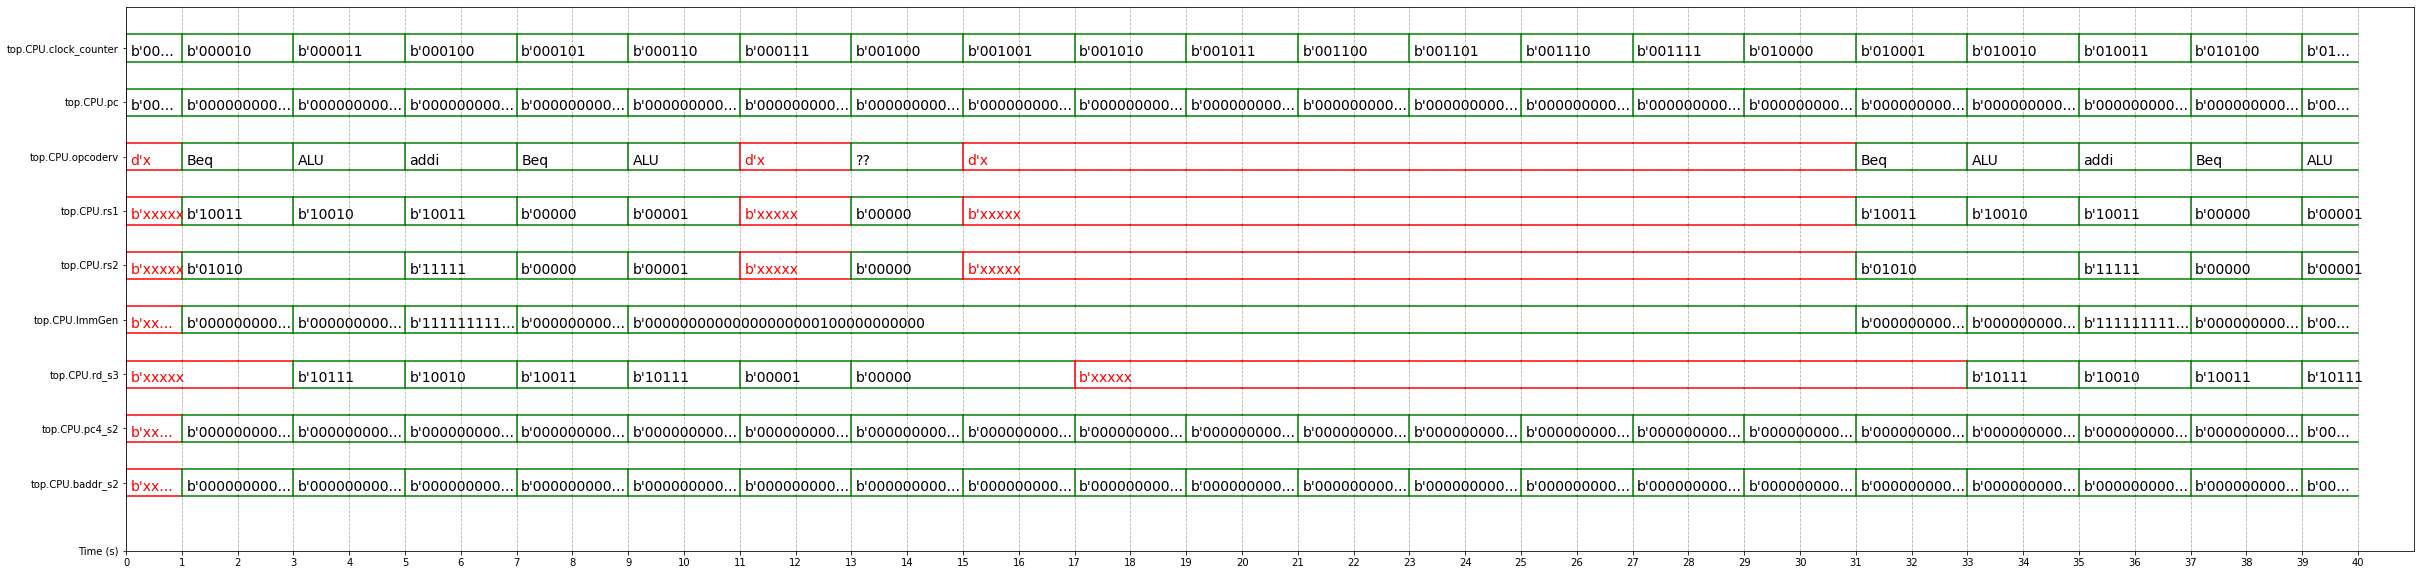

In [181]:
%%waveform test.vcd

op_dict = [{'10':'add','110':'sub'}, {'110011':'ALU','10011':'addi','11':'Lw', '1100011':'Beq'},{'10':'sp','111':'t2','1001':'s1', '1000':'s0','110':'t1','100':'tp','1':'ra','11':'gp', '101':'t0'} ]

sign_list = ['top.CPU.clock_counter', 'top.CPU.pc', 'top.CPU.opcoderv,r[1]' , 'top.CPU.rs1', 'top.CPU.rs2','top.CPU.ImmGen', 'top.CPU.rd_s3', 'top.CPU.pc4_s2', 'top.CPU.baddr_s2']
time_begin = 0
time_end = 40
base = 'bin' # bin, dec, dec2, hex, octal

##### Segundo Teste BEQ
* 0: nop
* 4: addi x1,x1,1
* 8: beq  x1,x3,4
* 12: beq x0,x0,-4
* 16: sub x1,x1,x4

In [182]:
%%writefile simple.s
addi x1,x0,0
addi x3,x0,3
addi x1,x1,1
beq x1,x3,4
beq x0,x0,4
sub x1,x1,x4

Overwriting simple.s


In [183]:
!rm -f -r simple/*
assemble()

------Writing to Text file------
Output file: simple.txt
Number of instructions: 6


In [184]:
%%verilog 
`include "main.v"

VCD info: dumpfile test.vcd opened for output.



In [185]:
!cat simple/txt/simple.txt

00000000000000000000000010010011
00000000001100000000000110010011
00000000000100001000000010010011
01111100001100001000101111100011
01111100000000000000101111100011
01000000010000001000000010110011


In [186]:
!cat im_data.txt

93
300193
108093
7c308be3
7c000be3
404080b3


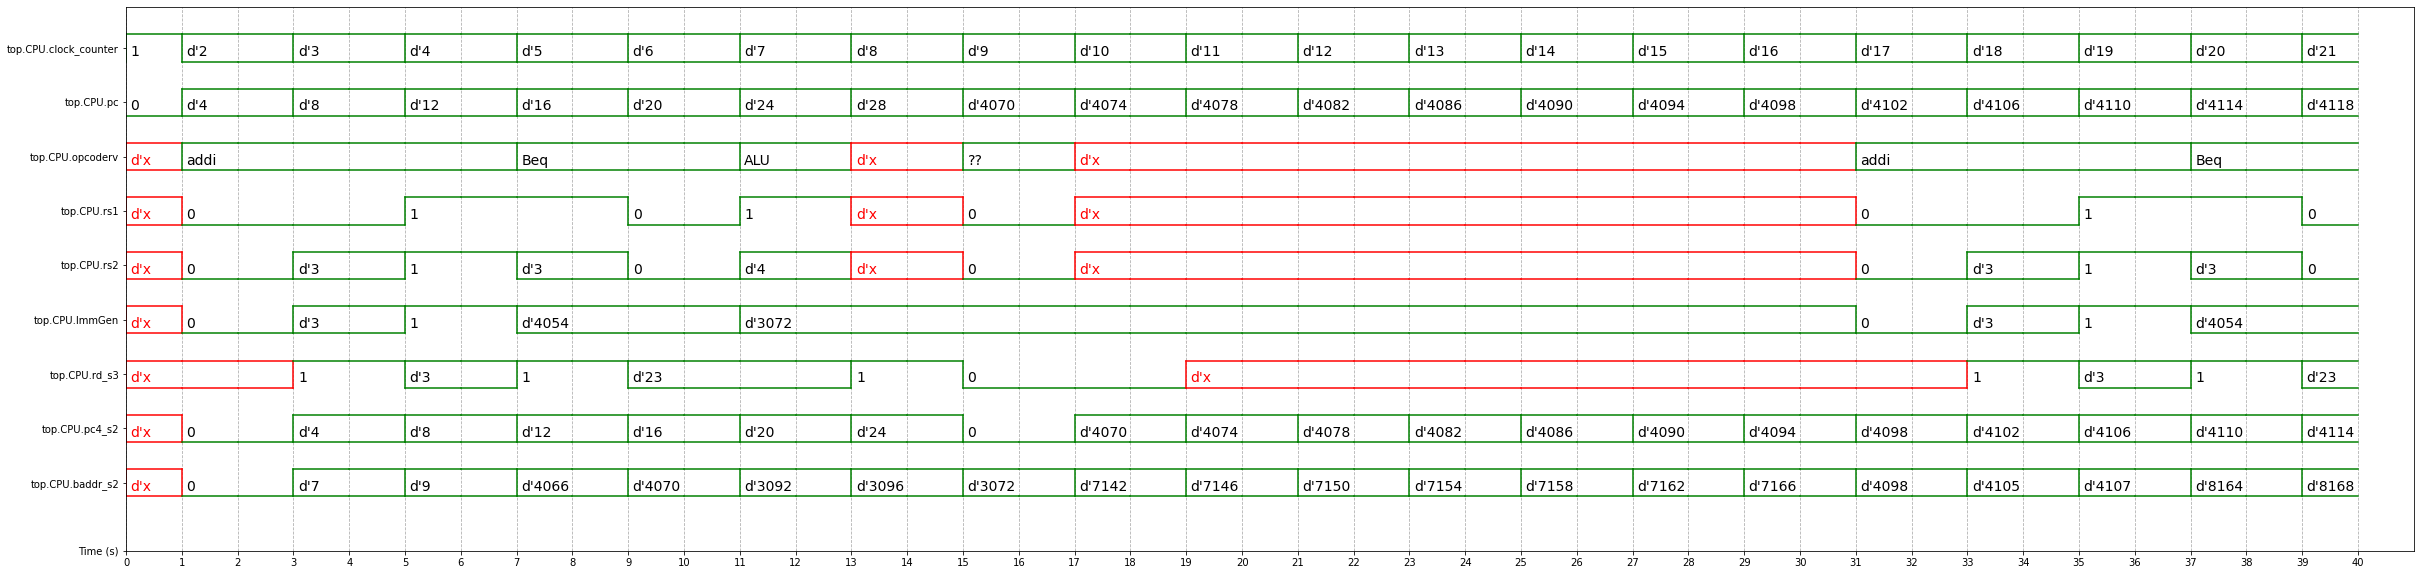

In [187]:
%%waveform test.vcd

op_dict = [{'10':'add','110':'sub'}, {'110011':'ALU','10011':'addi','11':'Lw', '1100011':'Beq'},{'10':'sp','111':'t2','1001':'s1', '1000':'s0','110':'t1','100':'tp','1':'ra','11':'gp', '101':'t0'} ]

sign_list = ['top.CPU.clock_counter', 'top.CPU.pc', 'top.CPU.opcoderv,r[1]' , 'top.CPU.rs1', 'top.CPU.rs2','top.CPU.ImmGen', 'top.CPU.rd_s3', 'top.CPU.pc4_s2', 'top.CPU.baddr_s2']
time_begin = 0
time_end = 40
base = 'dec' # bin, dec, dec2, hex, octal

###### Explicacao
```
                 4  8  12 16 20 24 4 8 12 16 20 16 20
0  nop           2  3  4  5  6  7  8 9 0  1  2  3  4
4  addi x1,x1,1  F  D  E  M  W     F D E  M  W           
8  beq x1,x3,4      F  D  E  M  W    F D  E  M  W
12 beq x0,x0,-4        F  D  E  M  W   F  D  E 
16 sub x1,x1,x4           F  D  E         F  D  F  D  E  M W
20                           F  D            F     F 
24                              F
```


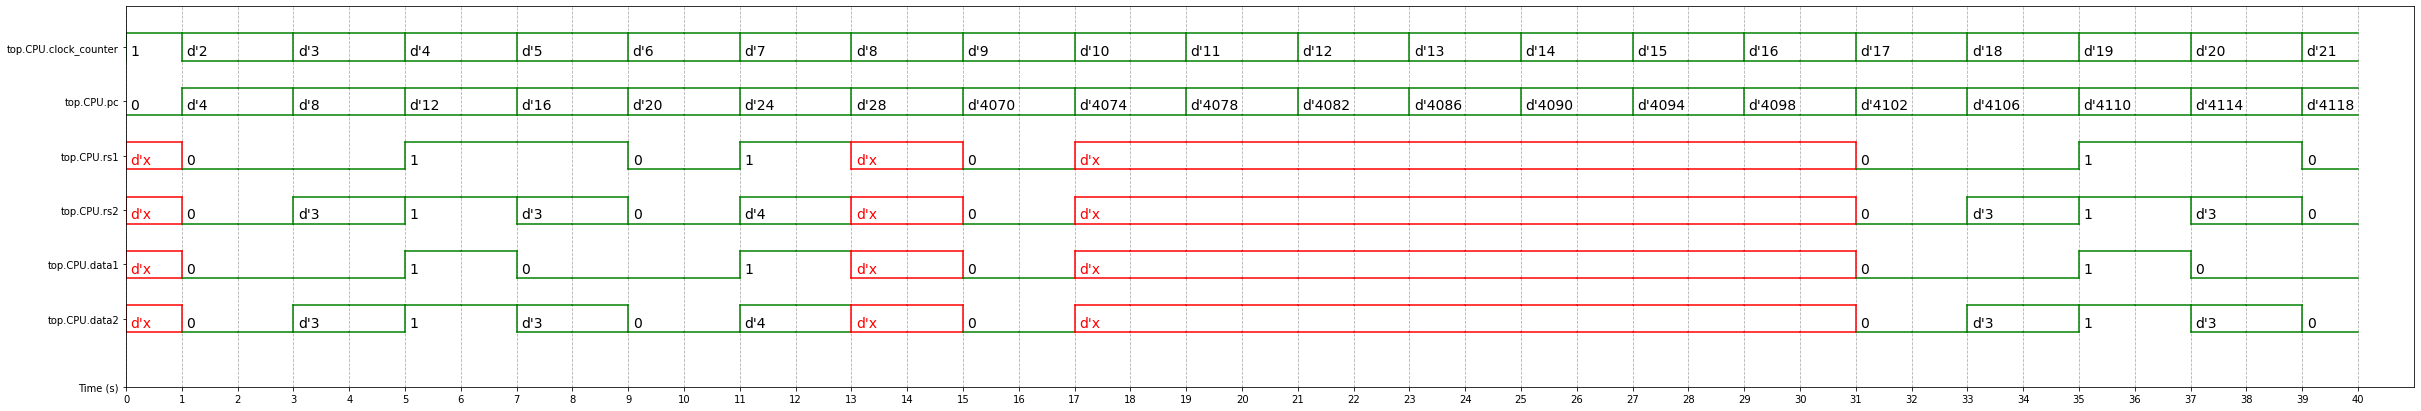

In [188]:
%%waveform test.vcd

op_dict = [{'10':'add','110':'sub'}, {'10':'sp','111':'t2','1001':'s1', '1000':'s0','110':'t1','100':'tp','1':'ra','11':'gp', '101':'t0'} ]

sign_list = ['top.CPU.clock_counter','top.CPU.pc','top.CPU.rs1','top.CPU.rs2','top.CPU.data1','top.CPU.data2']
time_begin = 0
time_end = 40
base = 'dec' # bin, dec, dec2, hex, octal


In [189]:
# Final Register file
!cat reg.data

// 0x00000000
00000000
00000001
00000002
00000003
00000004
00000005
00000006
00000007
00000008
00000009
0000000a
0000000b
0000000c
0000000d
0000000e
0000000f


### Memory Stage

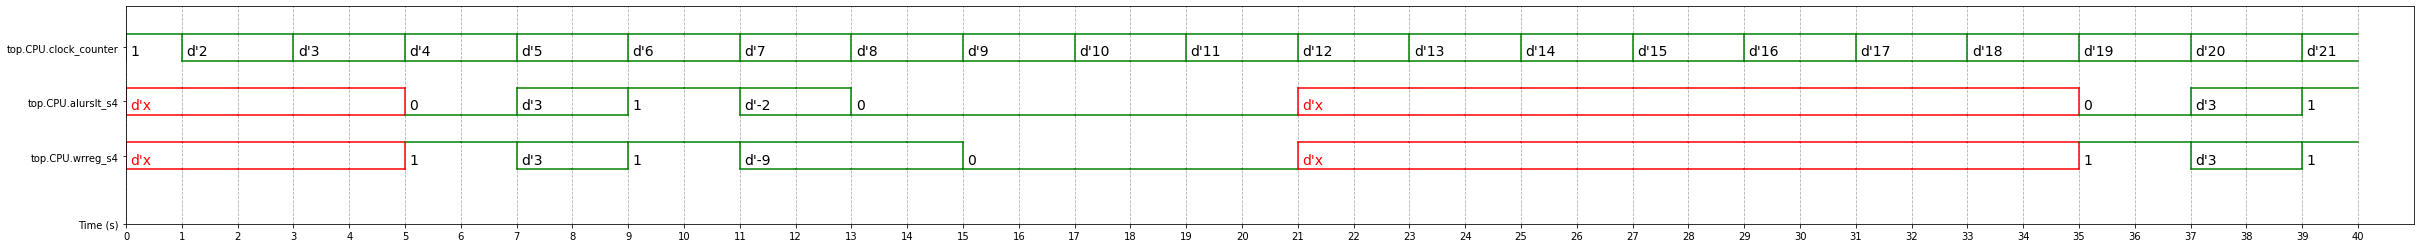

In [190]:
%%waveform test.vcd

op_dict = [{'10':'add','110':'sub'}, {'10':'sp','111':'t2','1001':'s1', '1000':'s0','110':'t1','100':'tp','1':'ra','11':'gp', '101':'t0'} ]

sign_list = ['top.CPU.clock_counter','top.CPU.alurslt_s4','top.CPU.wrreg_s4']
time_begin = 0
time_end = 40
base = 'dec2' # bin, dec, dec2, hex, octal


### Writback Stage

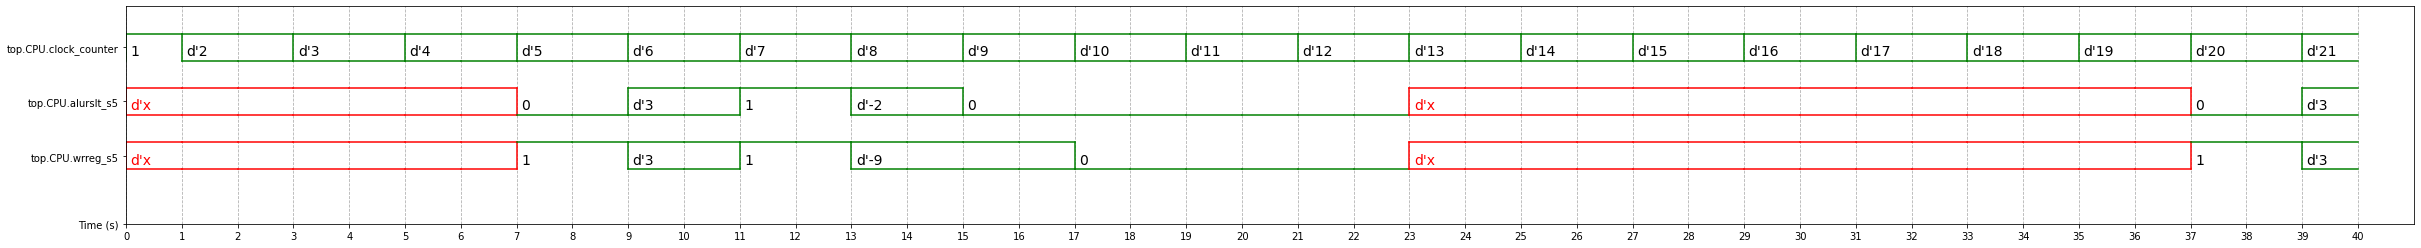

In [191]:
%%waveform test.vcd

op_dict = [{'10':'add','110':'sub'}, {'10':'sp','111':'t2','1001':'s1', '1000':'s0','110':'t1','100':'tp','1':'ra','11':'gp', '101':'t0'} ]

sign_list = ['top.CPU.clock_counter','top.CPU.alurslt_s5','top.CPU.wrreg_s5']
time_begin = 0
time_end = 40
base = 'dec2' # bin, dec, dec2, hex, octal


In [192]:
# Final Register file
!cat reg.data

// 0x00000000
00000000
00000001
00000002
00000003
00000004
00000005
00000006
00000007
00000008
00000009
0000000a
0000000b
0000000c
0000000d
0000000e
0000000f


In [193]:
# Final Data Memory
!cat mem.data 

// 0x00000000
00000000
00000001
00000002
00000003
00000004
00000005
00000006
00000007
00000008
00000009
00000010
00000011
00000012
00000013
00000014
00000015


# Testes

In [194]:
from ast import literal_eval
def check_diff(reg_data, reg_data_expected):
  data      = open(reg_data, "r")
  expected  = open(reg_data_expected, "r")
  
  #Leitura da primeira linha de ambos arquivos
  data.readline()
  expected.readline()
  #////

  erro_ocorreu = 0
 
  i = 0
  for data_line in data:
    expected_line = expected.readline()
    if(data_line != expected_line):
      erro_ocorreu = 1
      print(f"x{i}: esperado: {int(expected_line,16)}      recebido: {int(data_line,16)}")
    i += 1

  if(erro_ocorreu):
    raise Exception("Resultado diferente do esperado")

In [195]:
def tohex(val, nbits=32):
  s = hex((val + (1 << nbits)) % (1 << nbits)).replace('0x','')
  zeros = "0"*(8-len(s))
  return zeros+s

### Problema 1:  XORI -XOR immediate

In [196]:
%%writefile simple.s
addi x1,x0,4
addi x2,x0,-19
addi x3,x0,18
addi x4,x0,-4
xori x5,x1,-19
xori x6,x1,18
xori x7,x1,-4
xori x8,x2,18
xori x9,x2,-4
xori x10,x3,-4


Overwriting simple.s


In [197]:
!rm -f -r simple/*
assemble()

------Writing to Text file------
Output file: simple.txt
Number of instructions: 10


In [198]:
%%verilog 
`include "main.v"

VCD info: dumpfile test.vcd opened for output.



In [199]:
tohex(-4)

'fffffffc'

In [200]:
%%writefile reg.data.expected
// 0x00000000
00000000
00000004
ffffffed
00000012
fffffffc
ffffffe9
00000016
fffffff8
ffffffff
00000011
ffffffee
0000000b
0000000c
0000000d
0000000e
0000000f

Overwriting reg.data.expected


In [201]:
check_diff("reg.data","reg.data.expected")

Decode

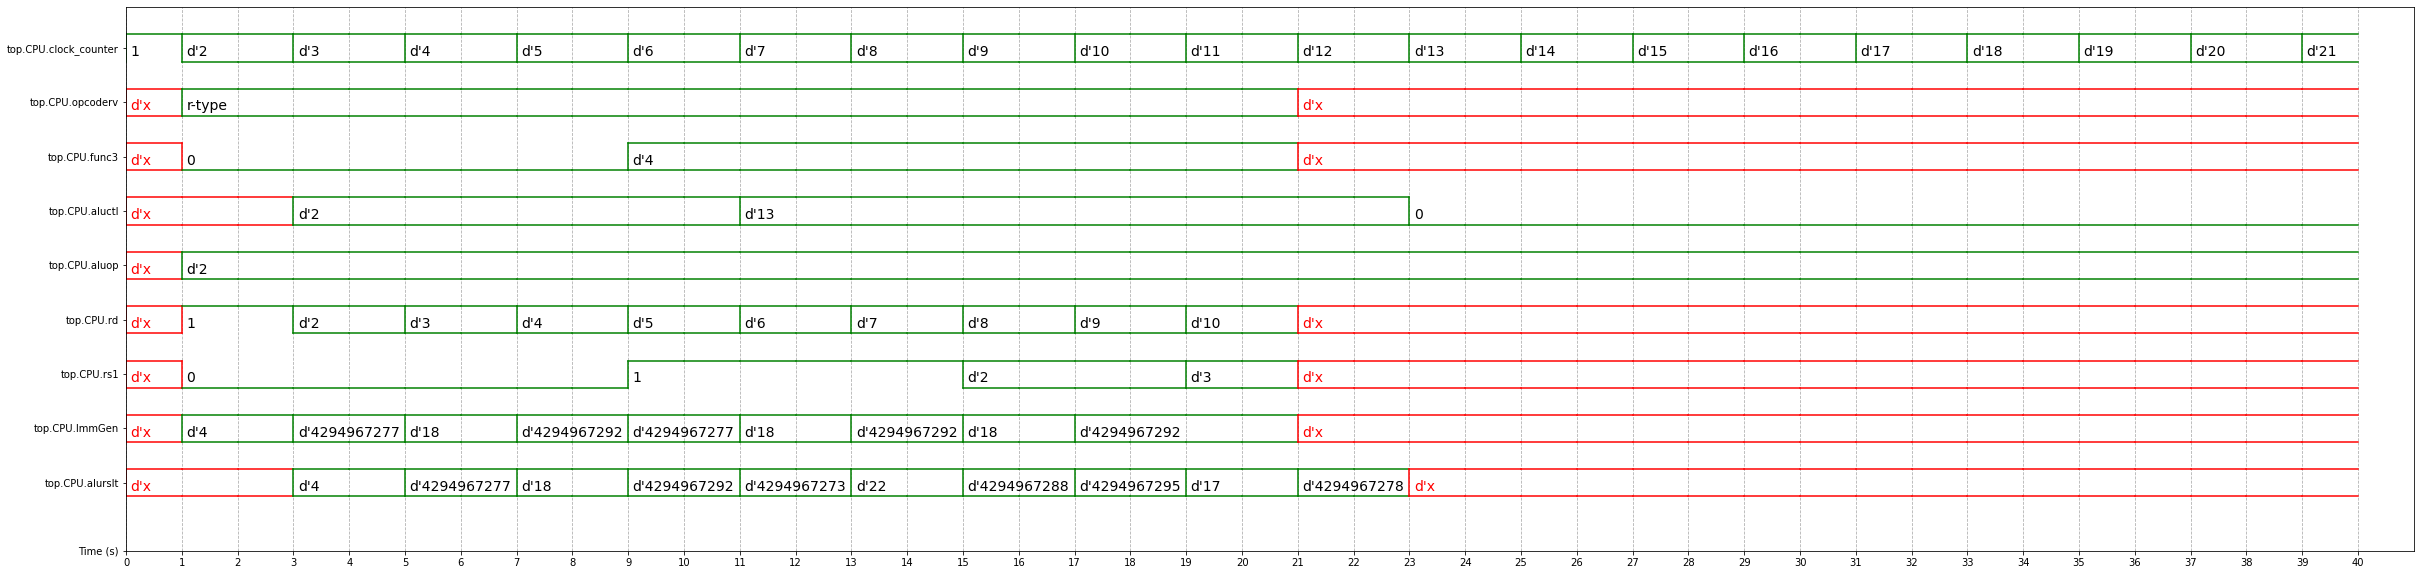

In [202]:
%%waveform test.vcd

op_dict = [{'10':'add','110':'sub'}, {'110011':'ALU','10011':'r-type'},{'10':'sp','111':'t2','1001':'s1', '1000':'s0','110':'t1','100':'tp','1':'ra','11':'gp', '101':'t0'} ]

sign_list = ['top.CPU.clock_counter','top.CPU.opcoderv,r[1]' , 'top.CPU.func3','top.CPU.aluctl','top.CPU.aluop', 'top.CPU.rd', 'top.CPU.rs1','top.CPU.ImmGen', 'top.CPU.alurslt']
time_begin = 0
time_end = 40
base = 'dec' # bin, dec, dec2, hex, octal


Execute

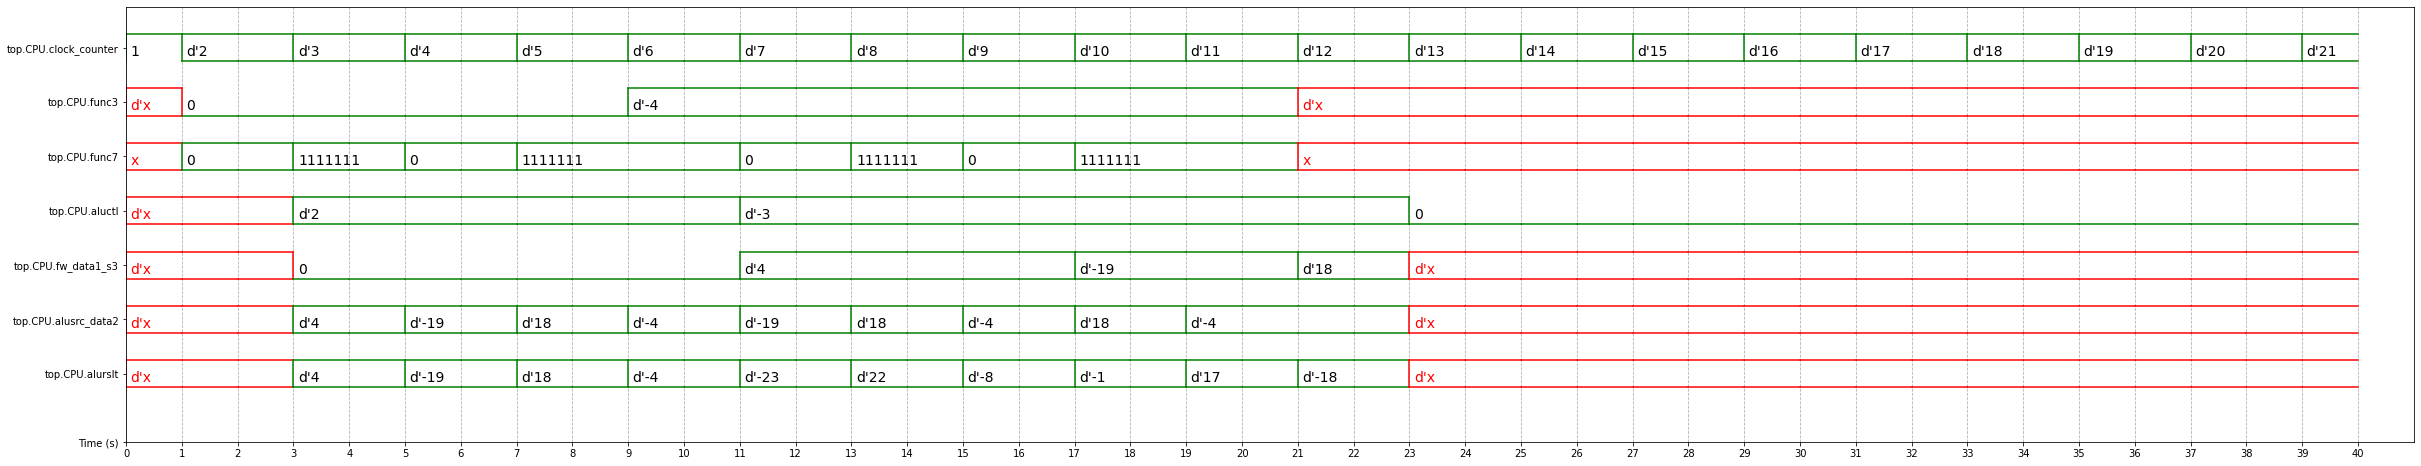

In [203]:
%%waveform test.vcd

op_dict = [{'10':'add','110':'sub','100':'xor'}, {'10':'sp','111':'t2','1001':'s1', '1000':'s0','110':'t1','100':'tp','1':'ra','11':'gp', '101':'t0'} ]

sign_list = ['top.CPU.clock_counter','top.CPU.func3', 'top.CPU.func7,b', 'top.CPU.aluctl' , 'top.CPU.fw_data1_s3', 'top.CPU.alusrc_data2','top.CPU.alurslt']
time_begin = 0
time_end = 40
base = 'dec2' # bin, dec, dec2, hex, octal

### Problema 2:  AND - And logic

In [204]:
%%writefile simple.s
addi x1,x0,4
addi x2,x0,19
addi x3,x0,18
addi x4,x0,-4
and x5,x1,x2
and x6,x1,x3
and x7,x1,x4
and x8,x2,x3
and x9,x2,x4
and x10,x3,x4


Overwriting simple.s


In [205]:
!rm -f -r simple/*
assemble()

------Writing to Text file------
Output file: simple.txt
Number of instructions: 10


In [206]:
%%verilog 
`include "main.v"

VCD info: dumpfile test.vcd opened for output.



In [207]:
%%writefile reg.data.expected
// 0x00000000
00000000
00000004
00000013
00000012
fffffffc
00000000
00000000
00000004
00000012
00000010
00000010
0000000b
0000000c
0000000d
0000000e
0000000f

Overwriting reg.data.expected


In [208]:
check_diff("reg.data","reg.data.expected")

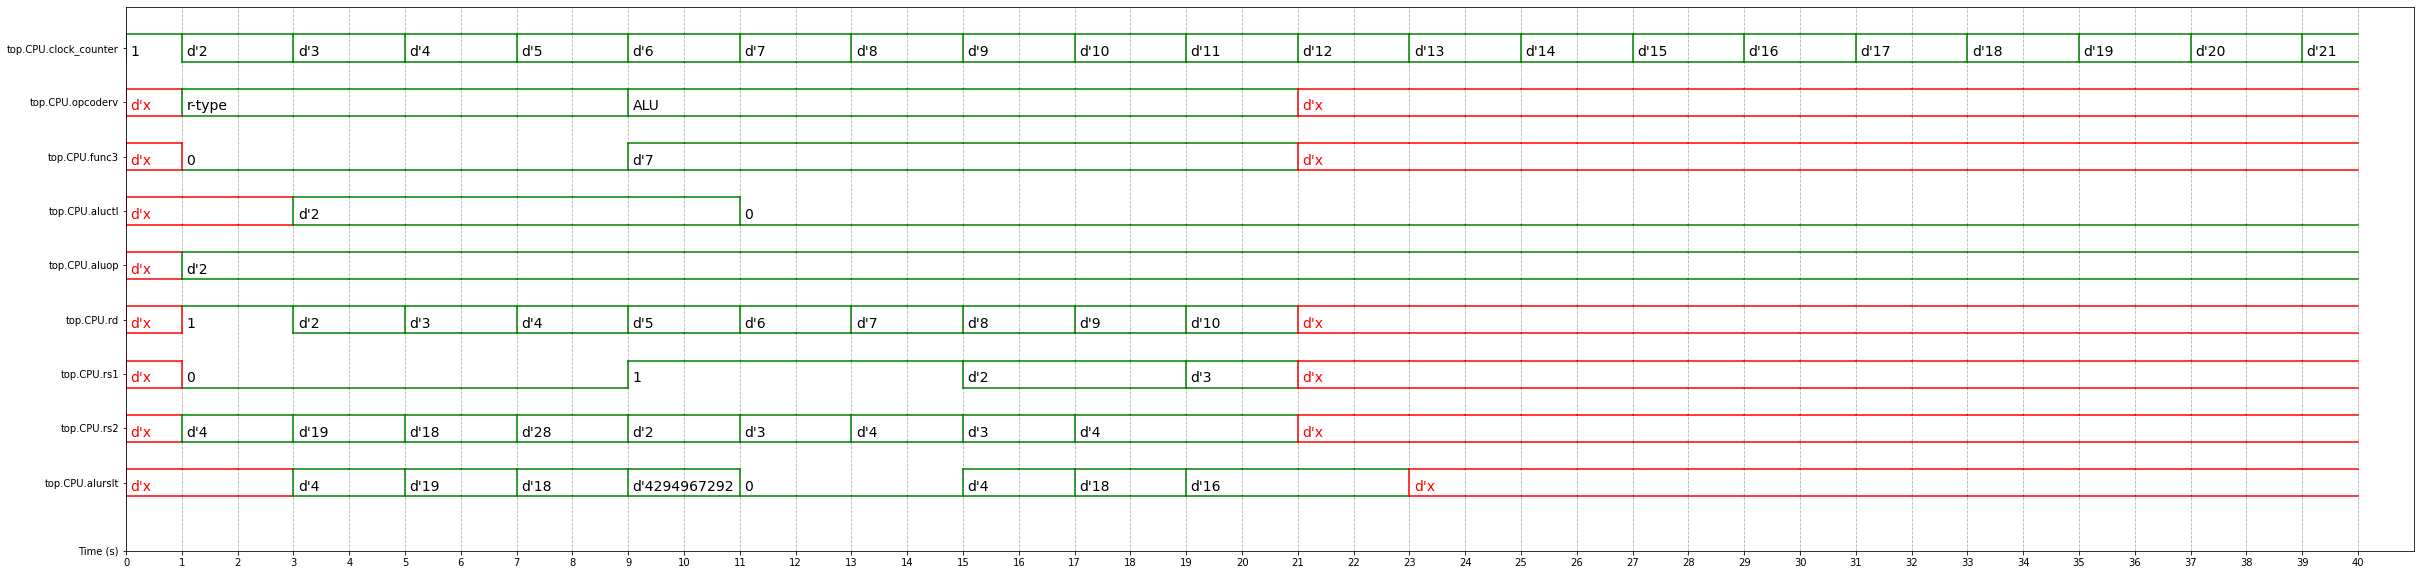

In [209]:
%%waveform test.vcd

op_dict = [{'10':'add','110':'sub'}, {'110011':'ALU','10011':'r-type'},{'10':'sp','111':'t2','1001':'s1', '1000':'s0','110':'t1','100':'tp','1':'ra','11':'gp', '101':'t0'} ]

sign_list = ['top.CPU.clock_counter','top.CPU.opcoderv,r[1]' , 'top.CPU.func3','top.CPU.aluctl','top.CPU.aluop', 'top.CPU.rd', 'top.CPU.rs1','top.CPU.rs2', 'top.CPU.alurslt']
time_begin = 0
time_end = 40
base = 'dec' # bin, dec, dec2, hex, octal


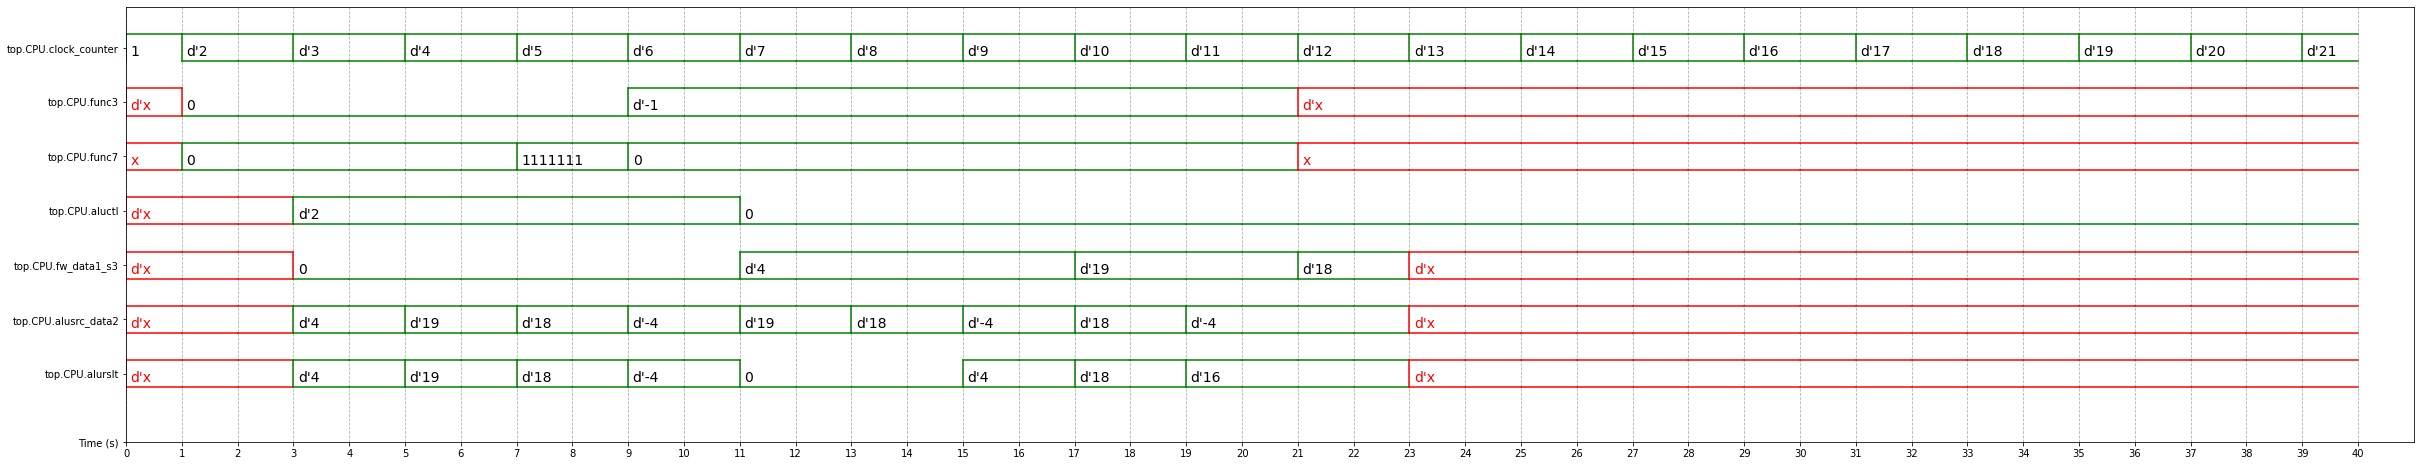

In [210]:
%%waveform test.vcd

op_dict = [{'10':'add','110':'sub','100':'xor'}, {'10':'sp','111':'t2','1001':'s1', '1000':'s0','110':'t1','100':'tp','1':'ra','11':'gp', '101':'t0'} ]

sign_list = ['top.CPU.clock_counter','top.CPU.func3', 'top.CPU.func7,b', 'top.CPU.aluctl' , 'top.CPU.fw_data1_s3', 'top.CPU.alusrc_data2','top.CPU.alurslt']
time_begin = 0
time_end = 40
base = 'dec2' # bin, dec, dec2, hex, octal

### Problema 3:  J - Jump



#### Teste 1

In [211]:
%%writefile simple.s
addi x8,x0,2
j funcao
addi x7,x0,-1
funcao:
addi x8,x0,0

Overwriting simple.s


In [212]:
!rm -f -r simple/*
assemble()

------Writing to Text file------
Output file: simple.txt
Number of instructions: 4


In [213]:
%%verilog 
`include "main.v"

VCD info: dumpfile test.vcd opened for output.



In [214]:
tohex(-1)

'ffffffff'

In [215]:
!cat simple/txt/simple.txt

00000000001000000000010000010011
00000000000000000100000001101111
11111111111100000000001110010011
00000000000000000000010000010011


In [216]:
%%writefile reg.data.expected
// 0x00000000
00000000
00000001
00000002
00000003
00000004
00000005
00000006
00000007
00000000
00000009
0000000a
0000000b
0000000c
0000000d
0000000e
0000000f

Overwriting reg.data.expected


In [217]:
check_diff("reg.data","reg.data.expected")

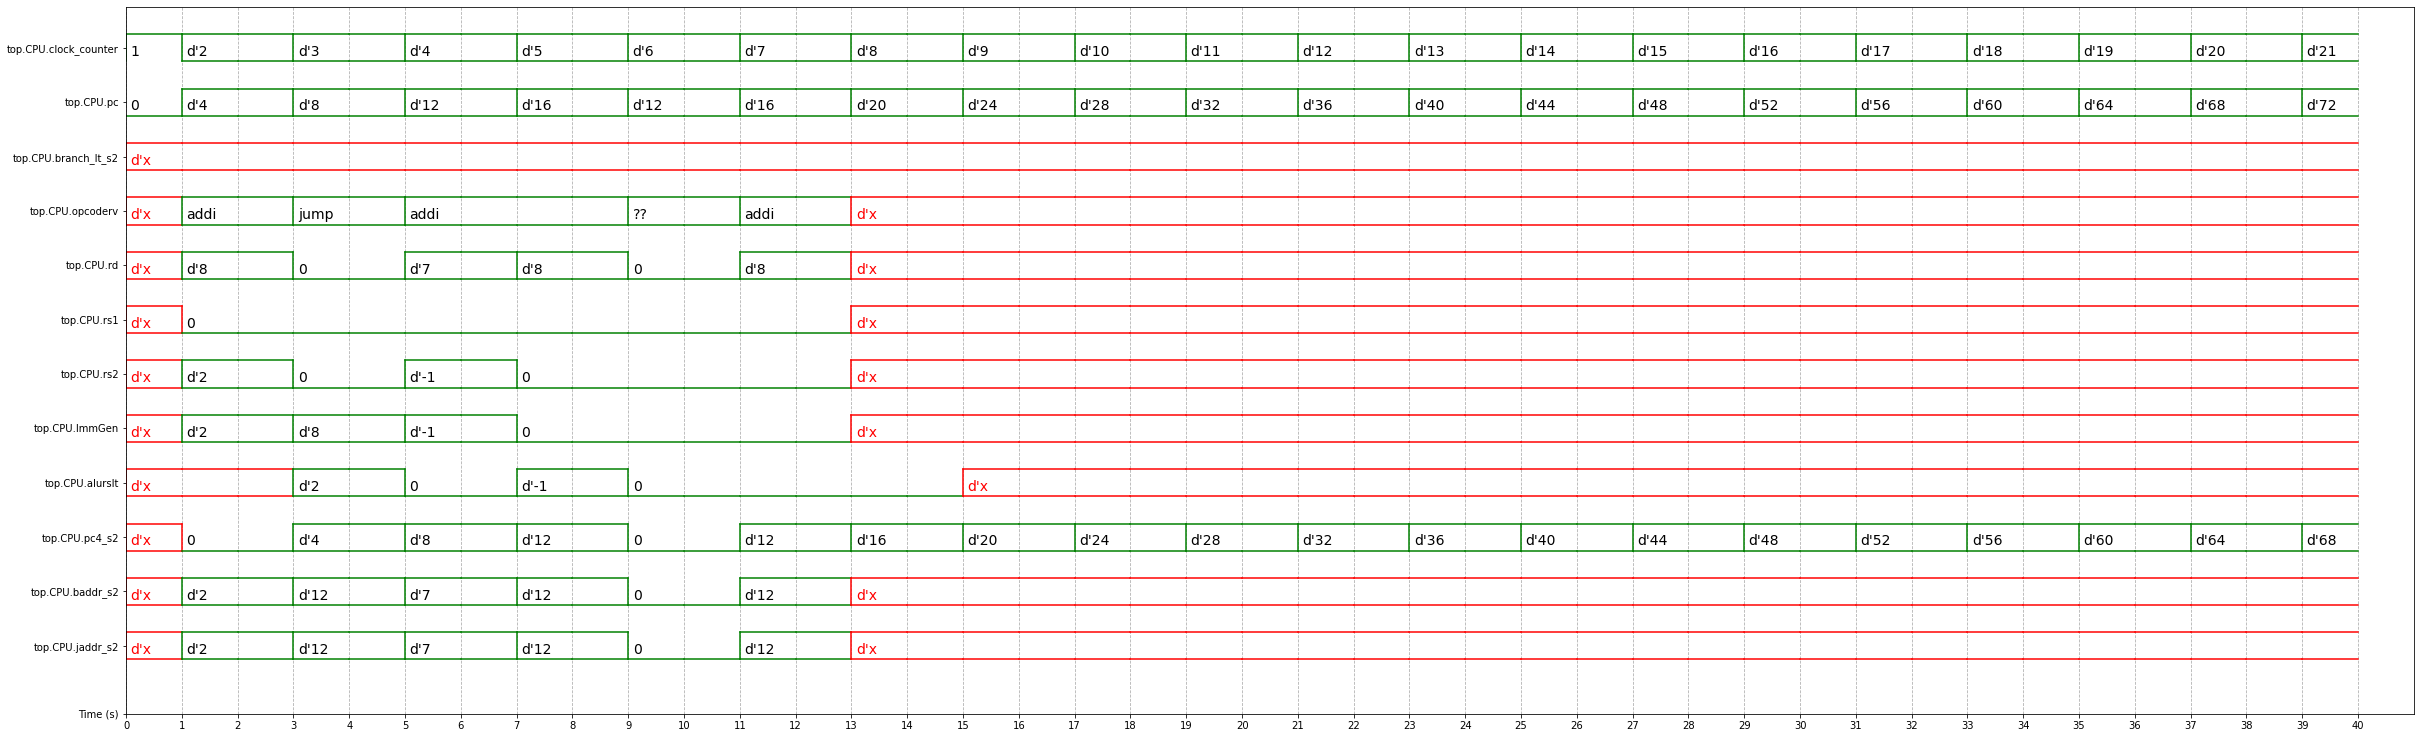

In [218]:
%%waveform test.vcd

op_dict = [{'10':'add','110':'sub'}, {'110011':'ALU','10011':'addi','11':'Lw', '1100011':'Beq','1101111':"jump"},{'00':'R','01':'I','10':'BLTU'},{'10':'sp','111':'t2','1001':'s1', '1000':'s0','110':'t1','100':'tp','1':'ra','11':'gp', '101':'t0'} ]

sign_list = ['top.CPU.clock_counter', 'top.CPU.pc','top.CPU.branch_lt_s2', 'top.CPU.opcoderv,r[1]' ,'top.CPU.rd', 'top.CPU.rs1', 'top.CPU.rs2','top.CPU.ImmGen','top.CPU.alurslt', 'top.CPU.pc4_s2', 'top.CPU.baddr_s2','top.CPU.jaddr_s2']
time_begin = 0
time_end = 40
base = 'dec2' # bin, dec, dec2, hex, octal

#### Teste 2

In [219]:
%%writefile simple.s
addi x8,x0,2
j funcao
addi x8,x0,-1
addi x8,x0,-1
addi x8,x0,-1
addi x8,x0,-1
addi x8,x0,-1
addi x7,x0,-1
funcao:
addi x8,x0,0

Overwriting simple.s


In [220]:
!rm -f -r simple/*
assemble()

------Writing to Text file------
Output file: simple.txt
Number of instructions: 9


In [221]:
%%verilog 
`include "main.v"

VCD info: dumpfile test.vcd opened for output.



In [222]:
%%writefile reg.data.expected
// 0x00000000
00000000
00000001
00000002
00000003
00000004
00000005
00000006
00000007
00000000
00000009
0000000a
0000000b
0000000c
0000000d
0000000e
0000000f

Overwriting reg.data.expected


In [223]:
check_diff("reg.data","reg.data.expected")

### Problema 4:  BLTU -Branch Less Than

#### Teste 1

In [224]:
%%writefile simple.s
nop
main:
addi x2,x0,2
addi x3,x0,3
bltu x2,x3,funcao
addi x7,x0,0
funcao:
addi x7,x0,-1

Overwriting simple.s


In [225]:
!rm -f -r simple/*
assemble()

------Writing to Text file------
Output file: simple.txt
Number of instructions: 6


In [226]:
%%verilog 
`include "main.v"

VCD info: dumpfile test.vcd opened for output.



In [227]:
%%writefile reg.data.expected
// 0x00000000
00000000
00000001
00000002
00000003
00000004
00000005
00000006
ffffffff
00000008
00000009
0000000a
0000000b
0000000c
0000000d
0000000e
0000000f

Overwriting reg.data.expected


In [228]:
check_diff("reg.data","reg.data.expected")

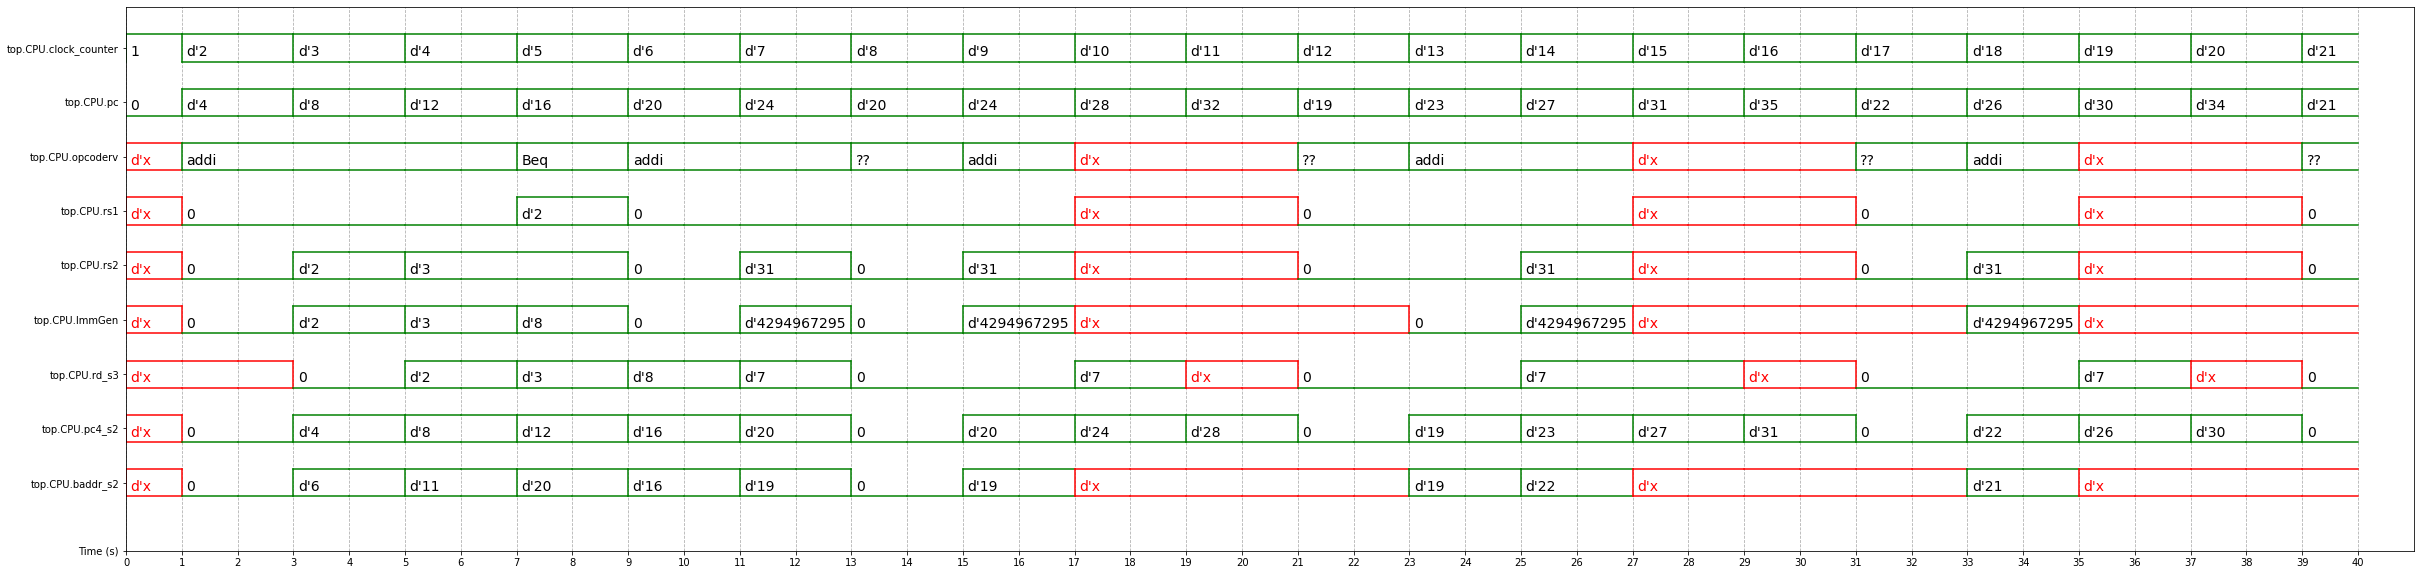

In [229]:
%%waveform test.vcd

op_dict = [{'10':'add','110':'sub'}, {'110011':'ALU','10011':'addi','11':'Lw', '1100011':'Beq'},{'10':'sp','111':'t2','1001':'s1', '1000':'s0','110':'t1','100':'tp','1':'ra','11':'gp', '101':'t0'} ]

sign_list = ['top.CPU.clock_counter', 'top.CPU.pc', 'top.CPU.opcoderv,r[1]' , 'top.CPU.rs1', 'top.CPU.rs2','top.CPU.ImmGen', 'top.CPU.rd_s3', 'top.CPU.pc4_s2', 'top.CPU.baddr_s2']
time_begin = 0
time_end = 40
base = 'dec' # bin, dec, dec2, a hex, octal

#### Teste 2

In [230]:
%%writefile simple.s
nop
main:
addi x2,x0,-4
addi x3,x0,3
bltu x2,x3,funcao
addi x8,x0,0
funcao:
addi x7,x0,-1

Overwriting simple.s


In [231]:
!rm -f -r simple/*
assemble()

------Writing to Text file------
Output file: simple.txt
Number of instructions: 6


In [232]:
%%verilog 
`include "main.v"

VCD info: dumpfile test.vcd opened for output.



In [233]:
tohex(-4)

'fffffffc'

In [234]:
%%writefile reg.data.expected
// 0x00000000
00000000
00000001
fffffffc
00000003
00000004
00000005
00000006
ffffffff
00000000
00000009
0000000a
0000000b
0000000c
0000000d
0000000e
0000000f

Overwriting reg.data.expected


In [235]:
check_diff("reg.data","reg.data.expected")

#### Teste 3

In [236]:
%%writefile simple.s
nop
main:
addi x2,x0,2
addi x3,x0,-3
bltu x2,x3,funcao
addi x7,x0,0
funcao:
addi x7,x0,-1

Overwriting simple.s


In [237]:
!rm -f -r simple/*
assemble()

------Writing to Text file------
Output file: simple.txt
Number of instructions: 6


In [238]:
%%verilog 
`include "main.v"

VCD info: dumpfile test.vcd opened for output.



In [239]:
%%writefile reg.data.expected
// 0x00000000
00000000
00000001
00000002
fffffffd
00000004
00000005
00000006
ffffffff
00000008
00000009
0000000a
0000000b
0000000c
0000000d
0000000e
0000000f

Overwriting reg.data.expected


In [240]:
check_diff("reg.data","reg.data.expected")

#### Teste 4

In [241]:
%%writefile simple.s
nop
main:
addi x2,x0,-2
addi x3,x0,-3
bltu x2,x3,funcao
addi x7,x0,0
funcao:
addi x7,x0,-1

Overwriting simple.s


In [242]:
!rm -f -r simple/*
assemble()

------Writing to Text file------
Output file: simple.txt
Number of instructions: 6


In [243]:
%%verilog 
`include "main.v"

VCD info: dumpfile test.vcd opened for output.



In [244]:
%%writefile reg.data.expected
// 0x00000000
00000000
00000001
fffffffe
fffffffd
00000004
00000005
00000006
ffffffff
00000008
00000009
0000000a
0000000b
0000000c
0000000d
0000000e
0000000f

Overwriting reg.data.expected


In [245]:
check_diff("reg.data","reg.data.expected")

#### Teste 5

In [246]:
%%writefile simple.s
nop
main:
addi x2,x0,-3
addi x3,x0,-2
bltu x2,x3,funcao

addi x7,x0,0
beq x0,x0,end


funcao:
addi x7,x0,-1
end:

Overwriting simple.s


In [247]:
!rm -f -r simple/*
assemble()

------Writing to Text file------
Output file: simple.txt
Number of instructions: 7


In [248]:
%%verilog 
`include "main.v"

VCD info: dumpfile test.vcd opened for output.



In [249]:
%%writefile reg.data.expected
// 0x00000000
00000000
00000001
fffffffd
fffffffe
00000004
00000005
00000006
00000000
00000008
00000009
0000000a
0000000b
0000000c
0000000d
0000000e
0000000f

Overwriting reg.data.expected


In [250]:
check_diff("reg.data","reg.data.expected")